# Preparación de datos

In [1]:
# importaciones
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from factor_analyzer.factor_analyzer import calculate_kmo, calculate_bartlett_sphericity

## Utilidades

In [2]:
EJECUCION_RAPIDA = False

seed=9603

dataset_path = "DB/"

db_files_name = ["df_train.csv", "df_test.csv"]

output_paths = ["output/", "../4_modelado/DB/"]

output_files_name = ["X_train.csv", "y_train.csv", "X_test.csv", "y_test.csv"]

caracteristicas_nominales = ['destination_port', 'label']

caracteristicas_binarias  = [
      'fwd_psh_flags', 'fwd_urg_flags',
      'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 
      'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 
      'cwe_flag_count', 'ece_flag_count'
]
      
caracteristicas_numericas = [
      'flow_duration', 'total_fwd_packets', 'total_backward_packets', 
      'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 
      'fwd_packet_length_max', 'fwd_packet_length_min', 
      'fwd_packet_length_mean', 'fwd_packet_length_std', 
      'bwd_packet_length_max', 'bwd_packet_length_min', 
      'bwd_packet_length_mean', 'bwd_packet_length_std', 
      'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 
      'flow_iat_min', 'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 
      'fwd_iat_max', 'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 
      'bwd_iat_std', 'bwd_iat_max', 'bwd_iat_min', 'fwd_header_length', 
      'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
      'min_packet_length', 'max_packet_length', 'packet_length_mean',
      'packet_length_std', 'packet_length_variance', 'down/up_ratio',
      'average_packet_size', 'avg_fwd_segment_size', 
      'avg_bwd_segment_size', 'fwd_header_length.1', 'subflow_fwd_packets', 
      'subflow_fwd_bytes', 'subflow_bwd_packets', 'subflow_bwd_bytes', 
      'init_win_bytes_forward', 'init_win_bytes_backward', 
      'act_data_pkt_fwd', 'min_seg_size_forward', 'active_mean', 
      'active_std', 'active_max', 'active_min', 'idle_mean', 'idle_std', 
      'idle_max', 'idle_min'
]

caracteristicas_no_utiles = [
      'bwd_psh_flags',
      'bwd_urg_flags', 
      'fwd_avg_bytes/bulk', 'fwd_avg_packets/bulk', 'fwd_avg_bulk_rate', 
      'bwd_avg_bytes/bulk', 'bwd_avg_packets/bulk', 'bwd_avg_bulk_rate'
]

caracteristicas_con_valor_maximo_infinito = [
      'flow_bytes/s', 'flow_packets/s'
]

In [3]:
# generateBoxplot(): Función para generar boxplot 
def generateBoxplot(x, y, data, save_path) :
  sns.boxplot(x=x, y=y, data=data)

  plt.xlabel(x)
  plt.ylabel(y)
  plt.savefig(save_path)
  plt.show()

In [4]:
# generateCorrMatrix(): Función para generar matriz de correlación
def generateCorrMatrix(data, save_path, title="Matriz de correlación", method="pearson", height=39, width=52, decimals=2) :
  # Generación de matriz de correlación
  matriz_correlacion = data.corr(method=method).abs()

  # Generación de mapa de calor para visualizar los datos
  plt.figure(figsize=(52, 39))

  sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title(title)
  plt.savefig(save_path)
  plt.show()

## Carga y transformación de datos

In [5]:
# Carga de datos
df = pd.read_csv(f"{dataset_path}{db_files_name[0]}")
print("Datos cargados")

Datos cargados


In [6]:
# Transformación de nombres de columnas
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(df.columns)
print(f"Total de características: {len(df.columns)}")

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags',
       'fwd_urg_flags', 'bwd_urg_flags', 'fwd_header_length',
       'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'fin_flag_count',
       'syn_flag_co

In [7]:
# Transformación de nombres de etiquetas de la columna label
df["label"] = df["label"].str.upper().str.replace("� ", "").str.replace(" ", "_").str.replace("-", "_")
print(df["label"].unique())
print(f"Total de etiquetas: {len(df["label"].unique())}")

['BENIGN' 'PORTSCAN' 'DOS_HULK' 'DDOS' 'DOS_GOLDENEYE' 'SSH_PATATOR'
 'DOS_SLOWHTTPTEST' 'FTP_PATATOR' 'BOT' 'WEB_ATTACK_BRUTE_FORCE'
 'DOS_SLOWLORIS' 'WEB_ATTACK_XSS']
Total de etiquetas: 12


## Selección de datos relevantes

In [8]:
# Eliminación de datos no relevantes
df = df.drop(caracteristicas_no_utiles, axis=1)
print(df.columns)
print(f"Características: {len(df.columns.tolist())}")

Index(['destination_port', 'flow_duration', 'total_fwd_packets',
       'total_backward_packets', 'total_length_of_fwd_packets',
       'total_length_of_bwd_packets', 'fwd_packet_length_max',
       'fwd_packet_length_min', 'fwd_packet_length_mean',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_mean',
       'bwd_packet_length_std', 'flow_bytes/s', 'flow_packets/s',
       'flow_iat_mean', 'flow_iat_std', 'flow_iat_max', 'flow_iat_min',
       'fwd_iat_total', 'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max',
       'fwd_iat_min', 'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std',
       'bwd_iat_max', 'bwd_iat_min', 'fwd_psh_flags', 'fwd_urg_flags',
       'fwd_header_length', 'bwd_header_length', 'fwd_packets/s',
       'bwd_packets/s', 'min_packet_length', 'max_packet_length',
       'packet_length_mean', 'packet_length_std', 'packet_length_variance',
       'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count',

## Limpieza de datos

### 1. Imputación de datos faltantes

#### 1.1. Valores nulos : flow_bytes/s

In [9]:
imputacion_con_filtro = True

if imputacion_con_filtro :
  print(df[df["flow_bytes/s"].isna()]["label"].value_counts())
  null_values_list = df[df["flow_bytes/s"].isna()]["label"].unique().tolist()

  for i in null_values_list : 
    median = df[df["label"] == i]["flow_bytes/s"].median()
    print(f"Mediana de la característica flow_bytes/s en la etiqueta {i}: {median}")

    df.loc[df["flow_bytes/s"].isnull() & (df["label"] == i), "flow_bytes/s"] = median

    rest = df[df["label"] == i]["flow_bytes/s"].isnull().sum()

    print(f"Valores faltantes en flow_bytes/s en {i} después de la imputación: {rest}")
else : 
  mediana = df["flow_bytes/s"].median()
  print(f"Mediana de la característica flow_bytes/s: {mediana}\n")
  df["flow_bytes/s"] = df["flow_bytes/s"].fillna(mediana)
  print(f"Valores faltantes en flow_bytes/s: {df["flow_bytes/s"].isnull().sum()}")

label
DOS_HULK    49
BENIGN      19
Name: count, dtype: int64
Mediana de la característica flow_bytes/s en la etiqueta DOS_HULK: 121.2098375
Valores faltantes en flow_bytes/s en DOS_HULK después de la imputación: 0
Mediana de la característica flow_bytes/s en la etiqueta BENIGN: 5148.915010500001
Valores faltantes en flow_bytes/s en BENIGN después de la imputación: 0


### 2. Valores infinitos y outliers

In [10]:
# manageOutliersToMinMax() : Función para manejar outliers y transformarlos a los valores mínimos y máximos en un boxplot
def manageOutliersToMinMax(df : pd.DataFrame, col_num, col_obj) :
  df_modificado = df.copy()
  for var_obj in df[col_obj].unique() :
    subset = df[df[col_obj] == var_obj]
    q1 = subset[col_num].quantile(0.25)
    q3 = subset[col_num].quantile(0.75) 
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    valid_values = subset[(subset[col_num] >= lower_bound) & (subset[col_num] <= upper_bound)][col_num]
    valid_min = valid_values.min()
    valid_max = valid_values.max()

    mask = df[col_obj] == var_obj
    df_modificado.loc[mask & (df[col_num] < lower_bound), col_num] = valid_min
    df_modificado.loc[mask & (df[col_num] > upper_bound), col_num] = valid_max
  return df_modificado

In [11]:
# Manejo de outliers para ajustarlos al máximo y mínimo del conjunto de datos
for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito : 
  df = manageOutliersToMinMax(df=df,col_num=i,col_obj="label")

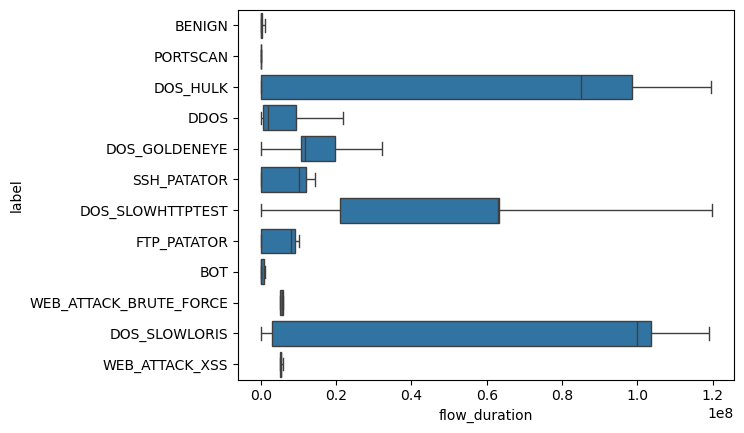

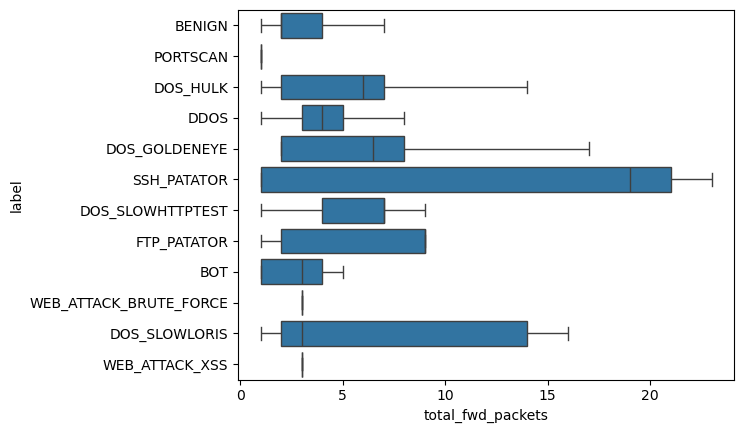

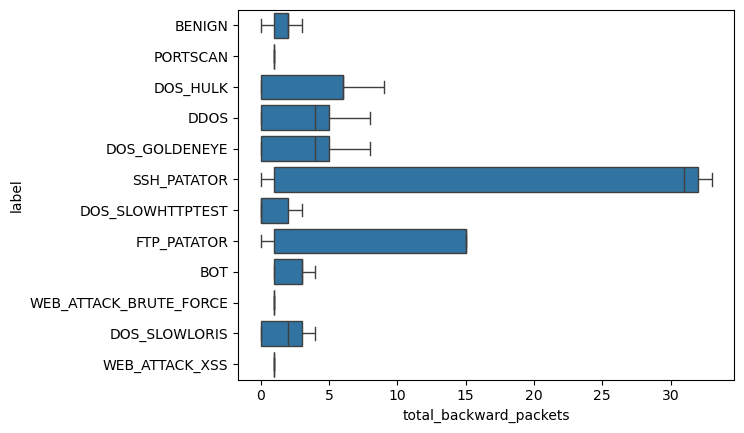

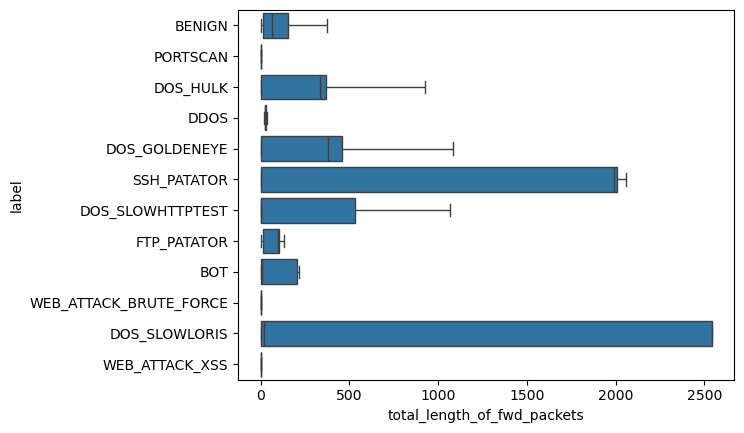

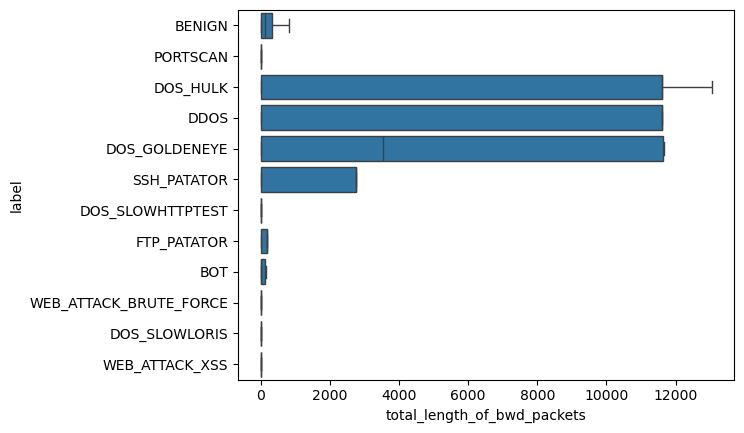

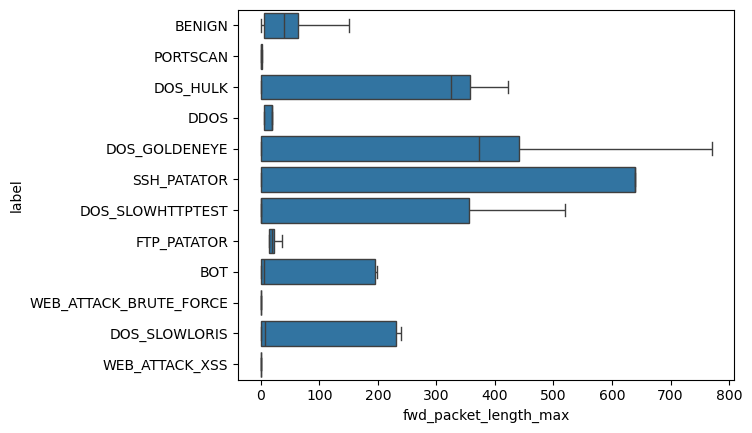

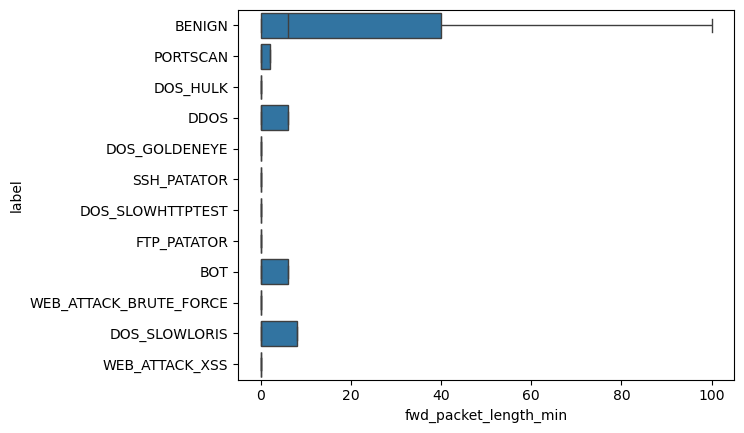

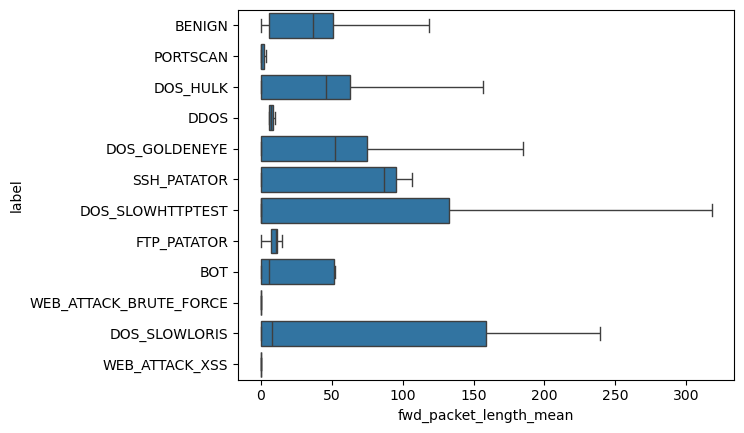

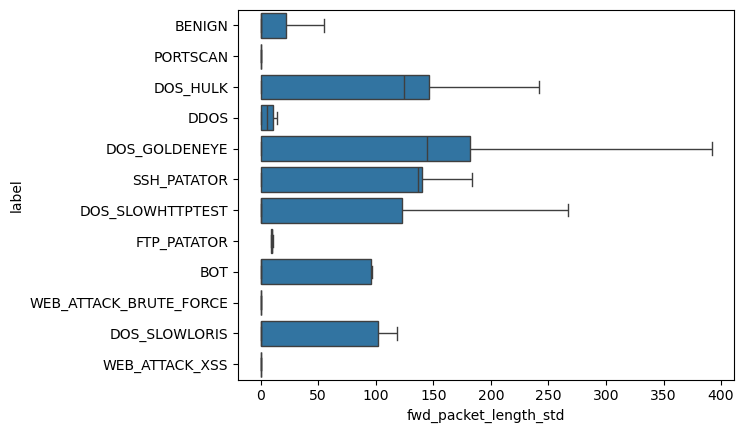

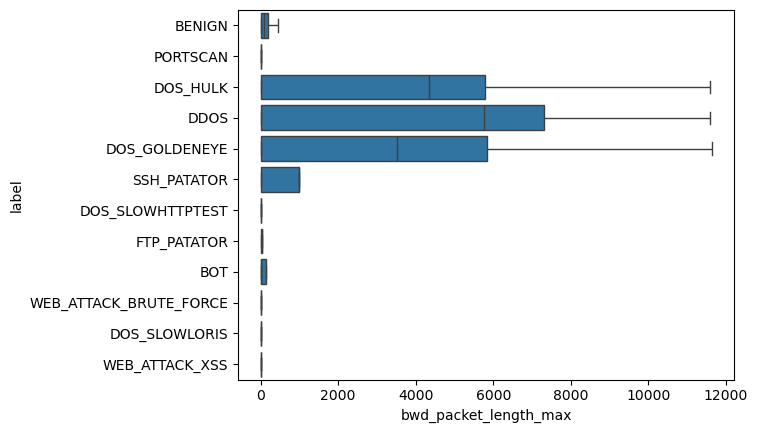

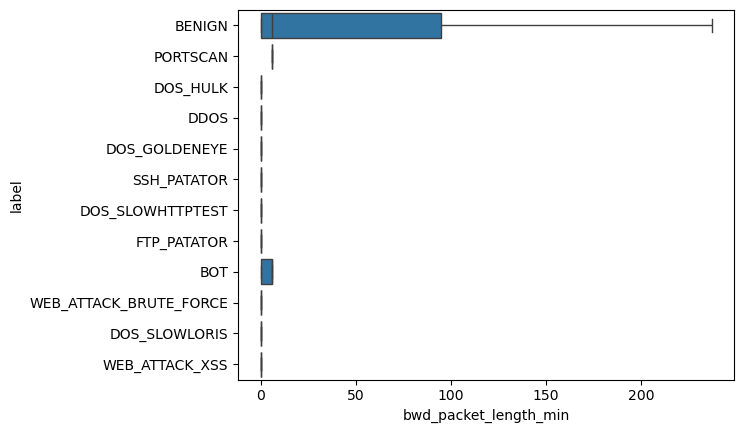

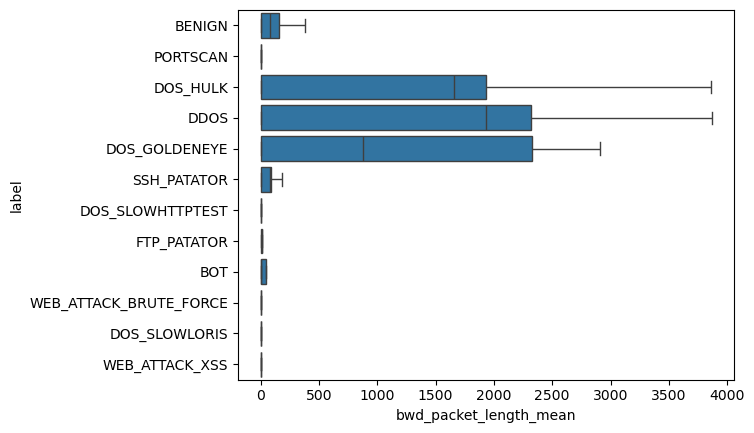

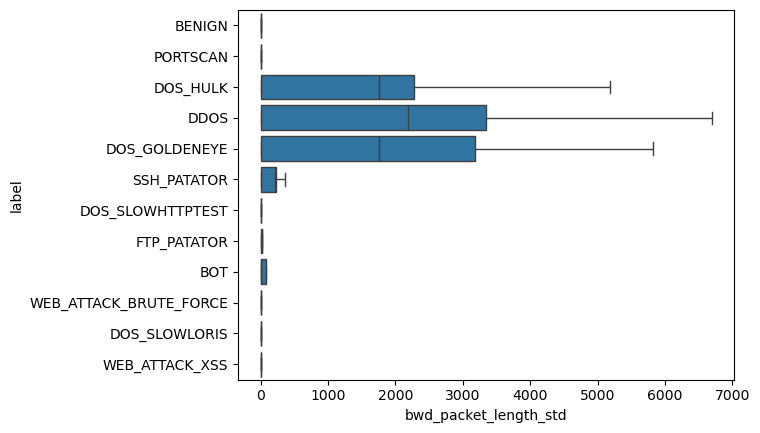

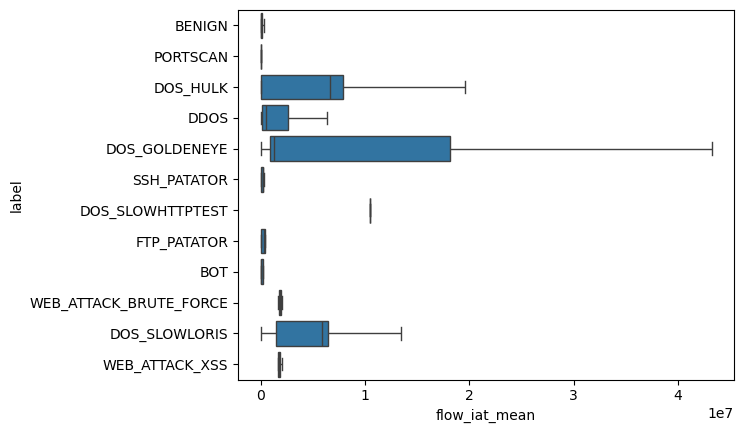

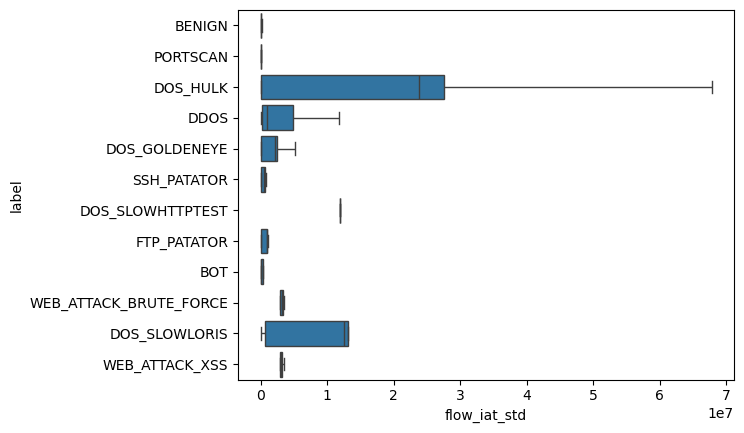

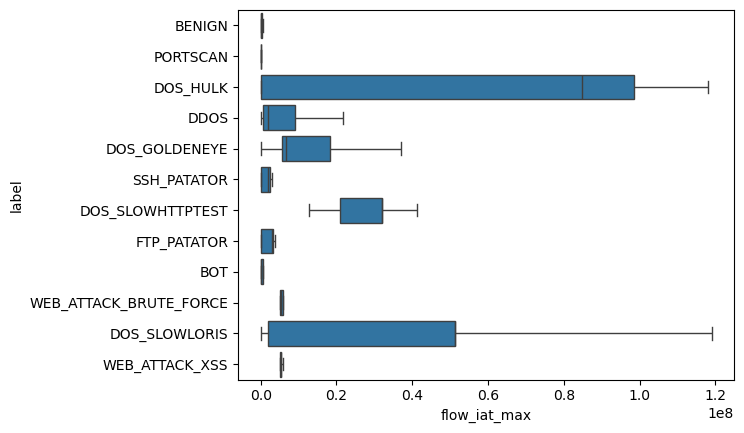

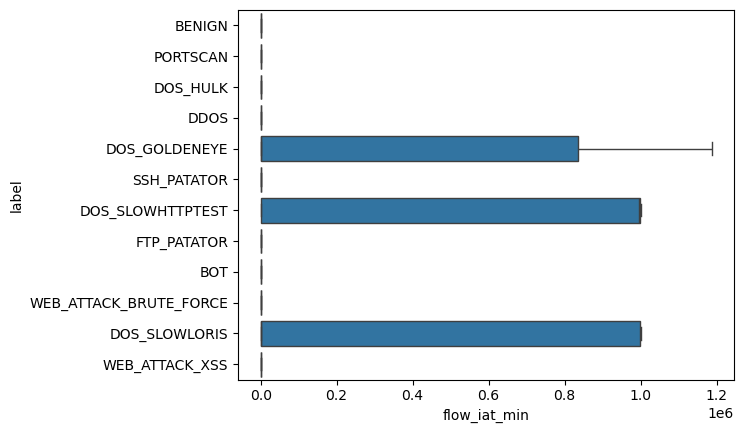

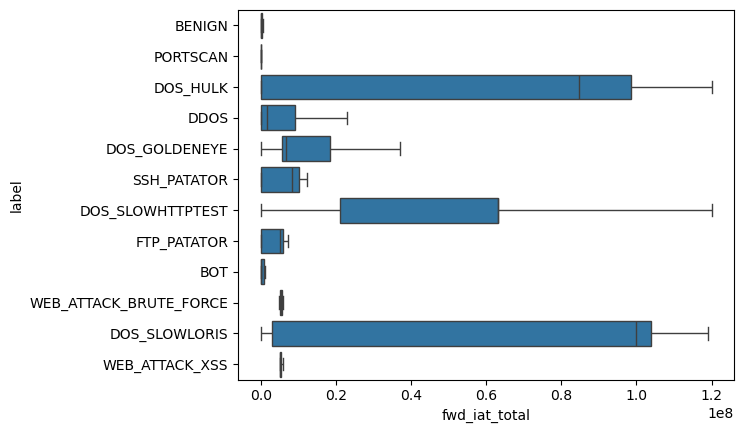

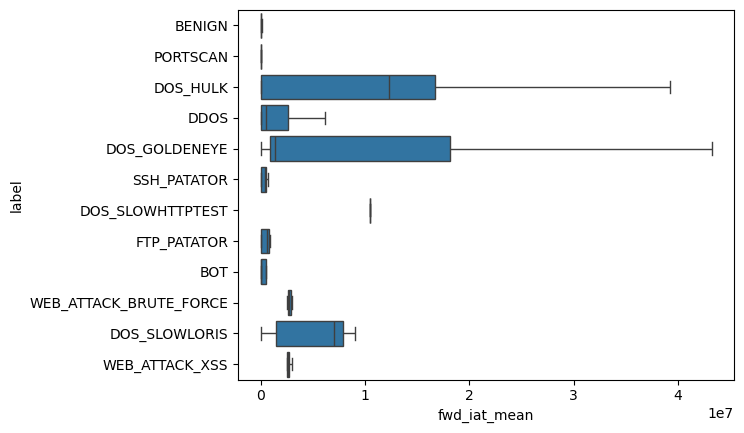

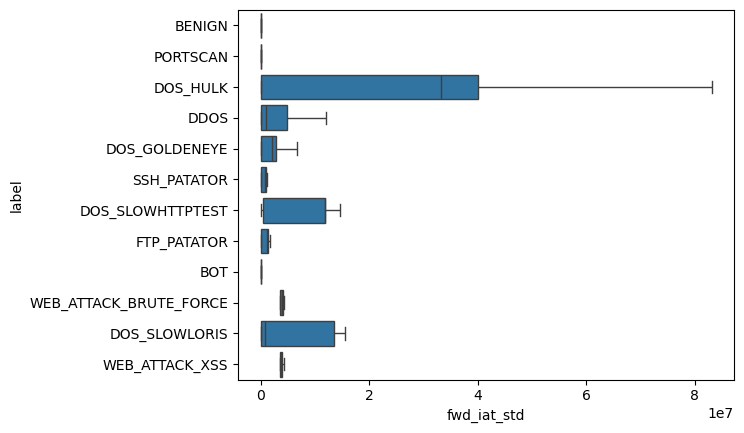

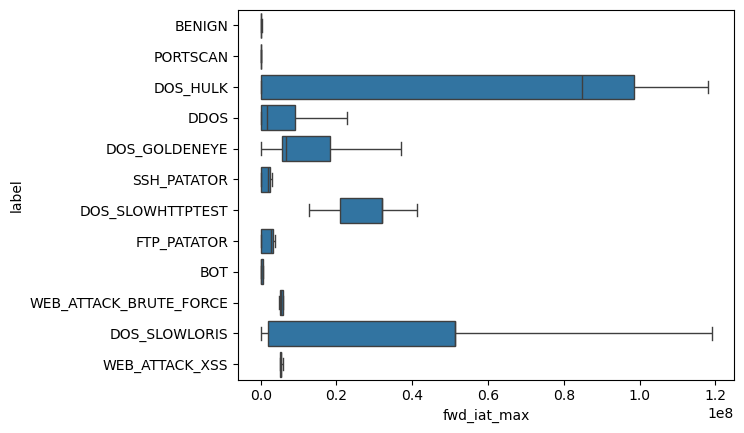

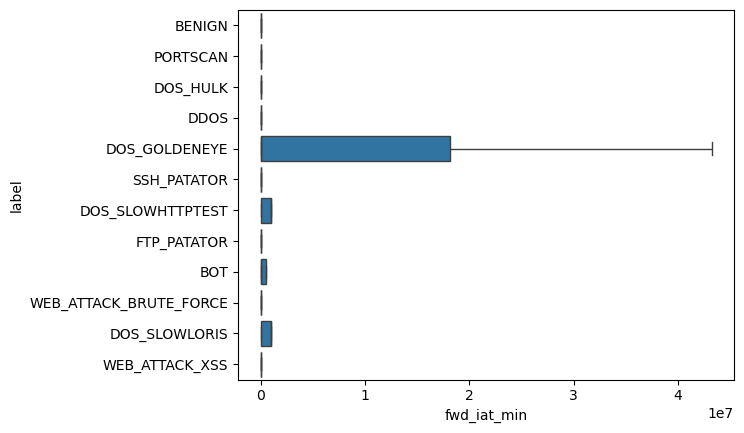

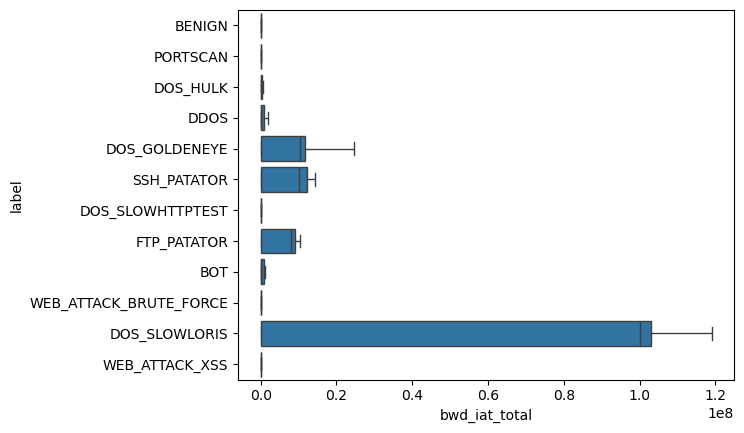

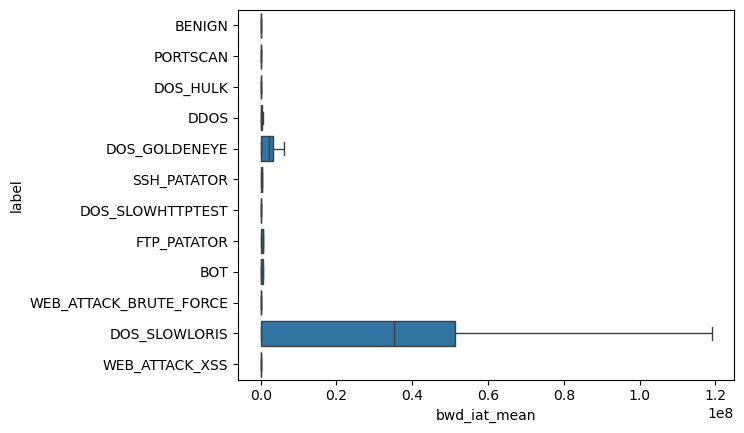

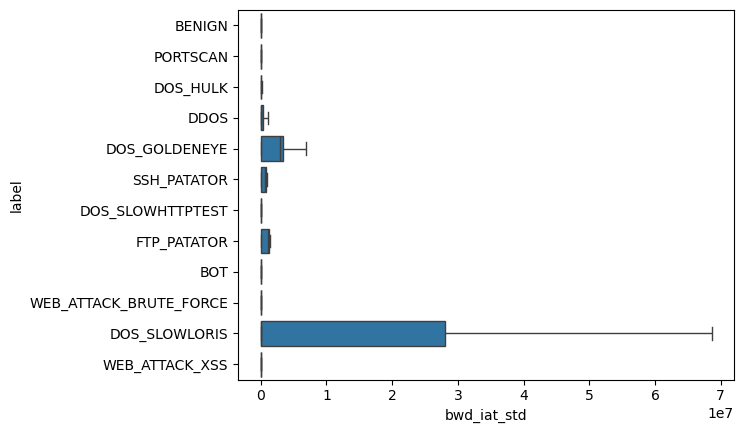

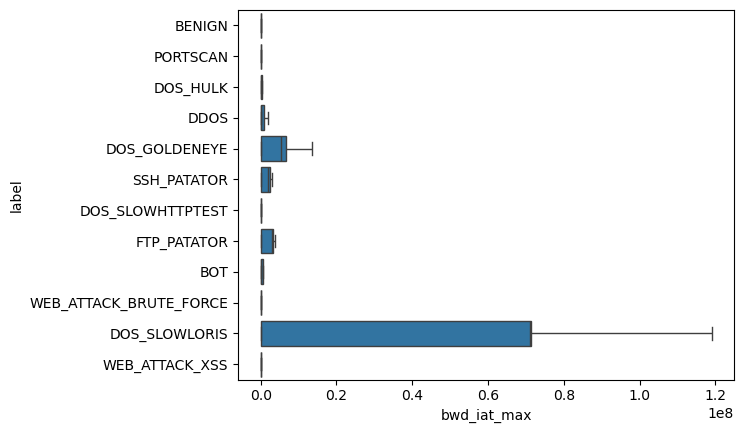

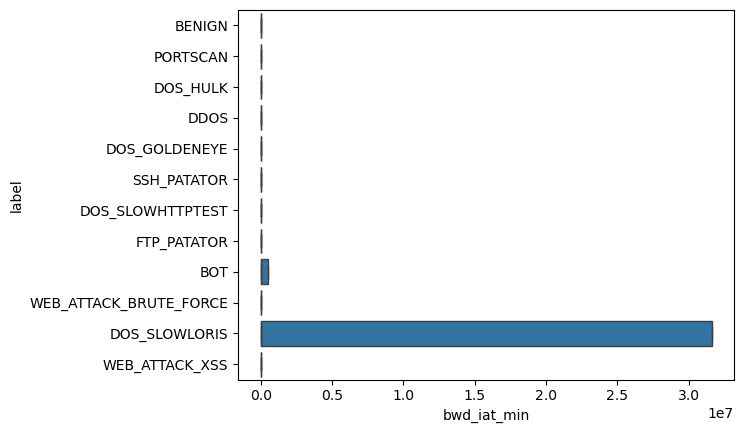

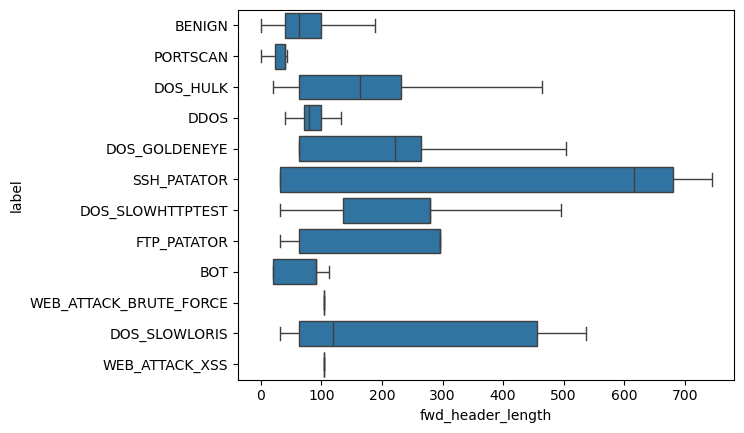

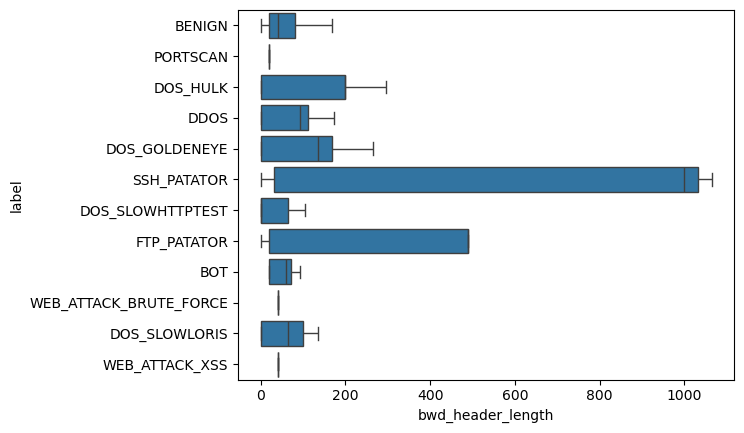

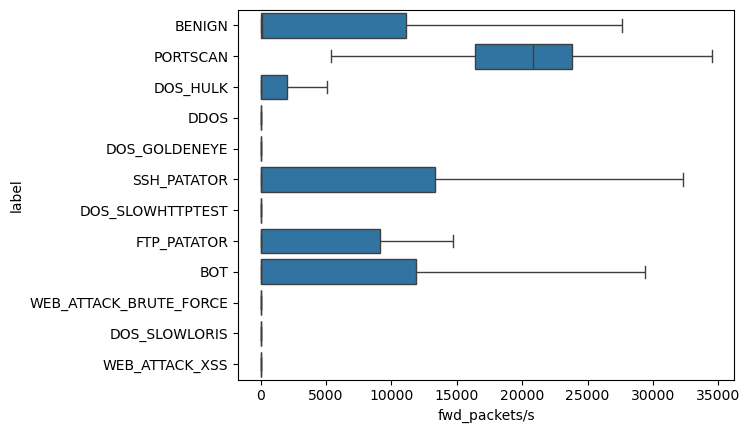

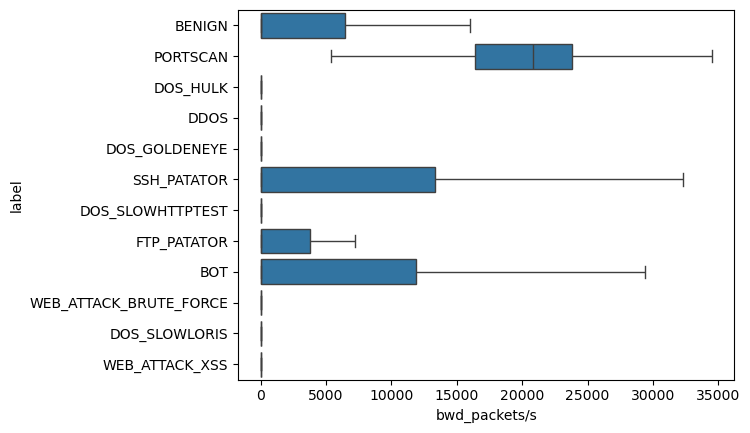

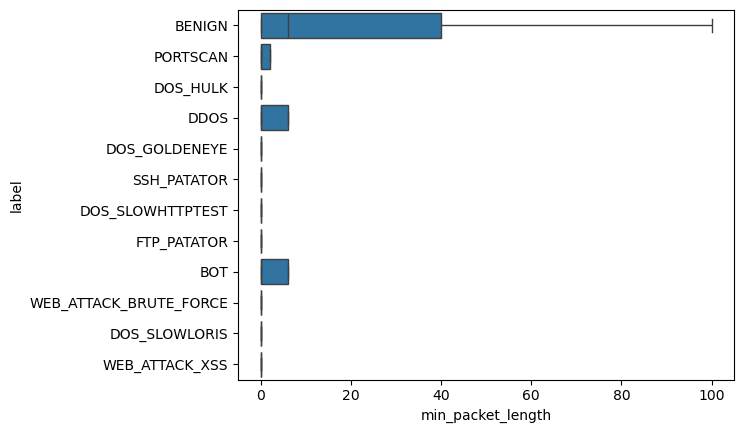

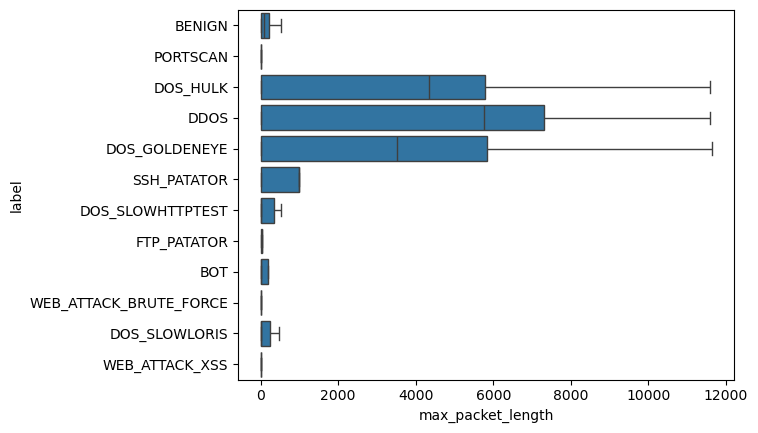

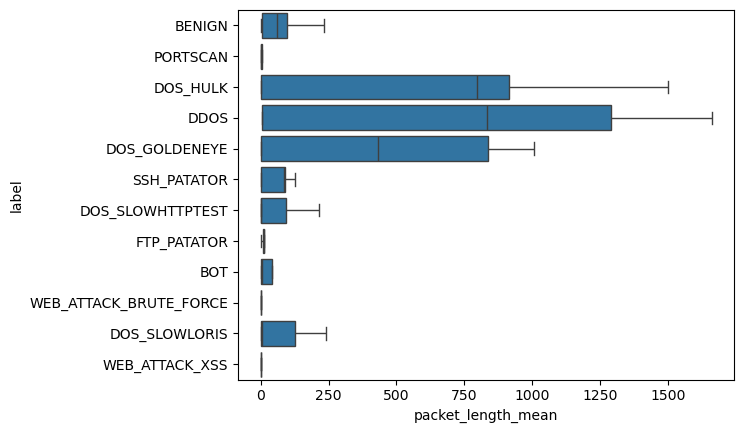

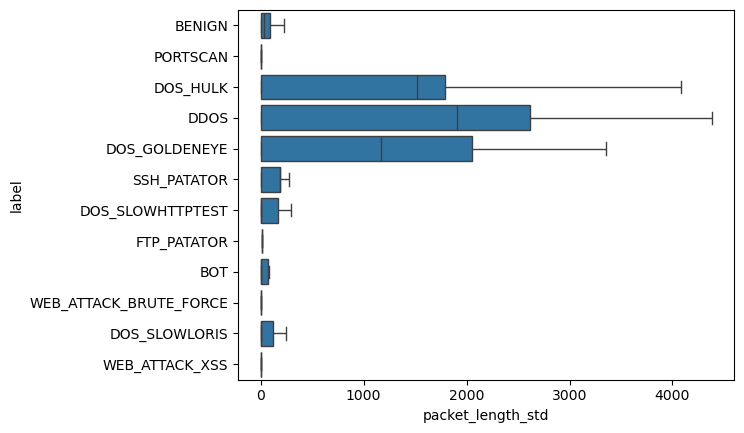

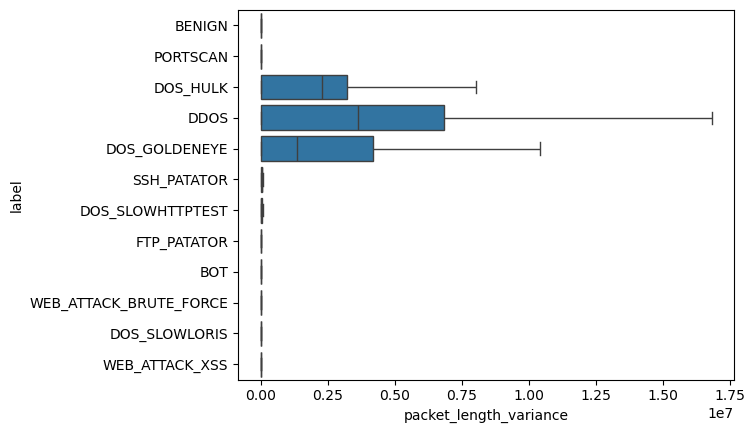

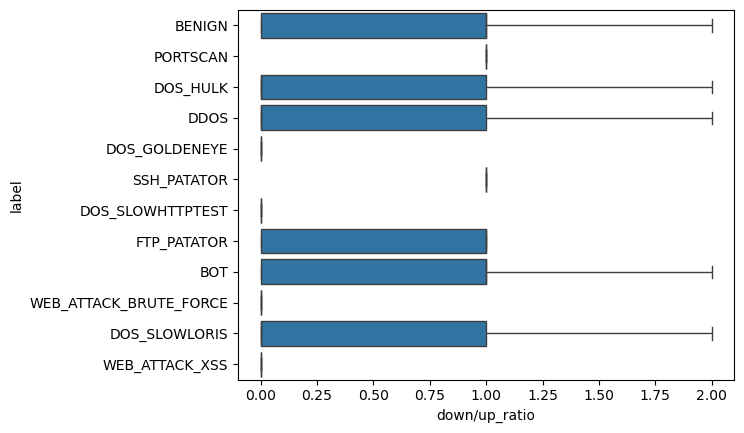

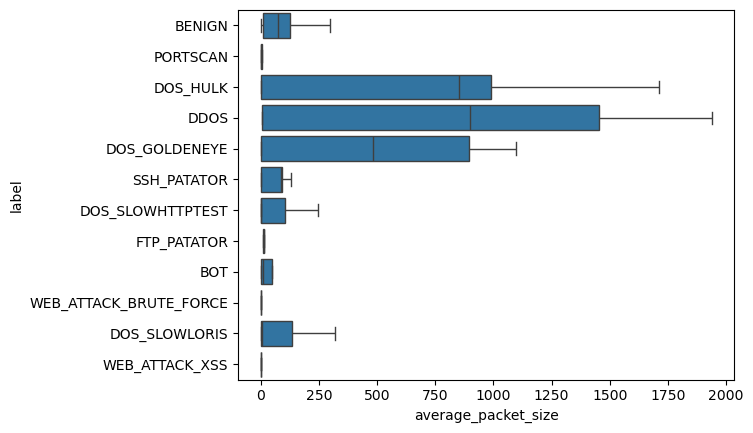

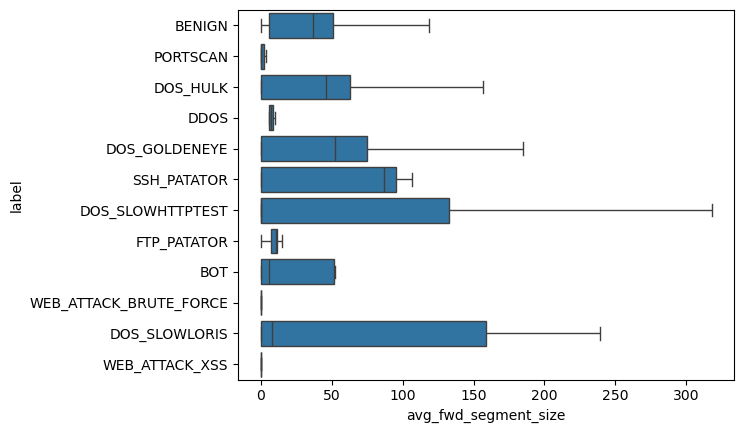

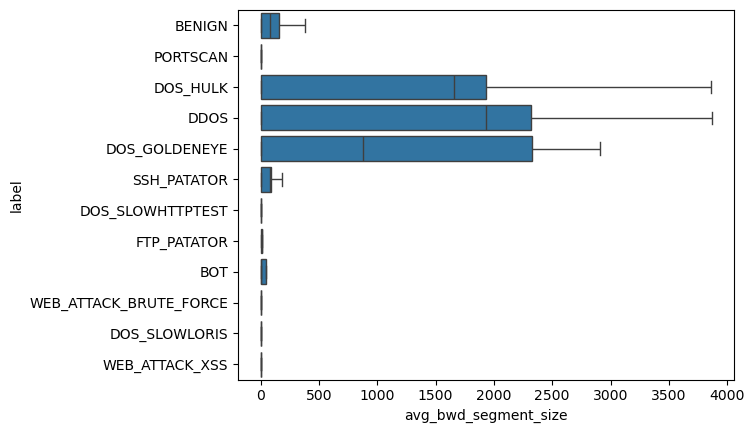

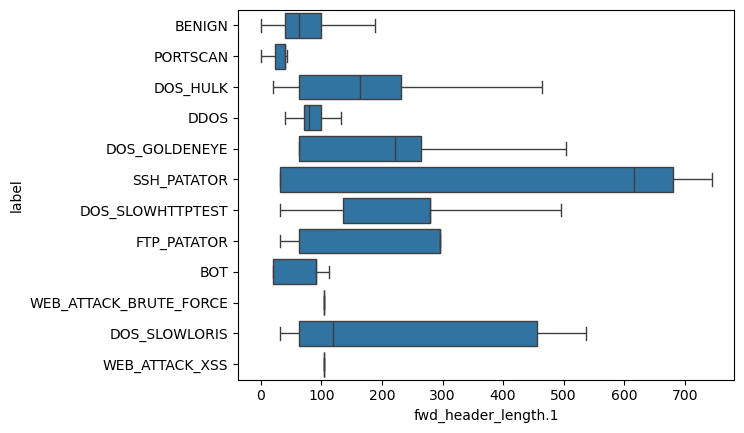

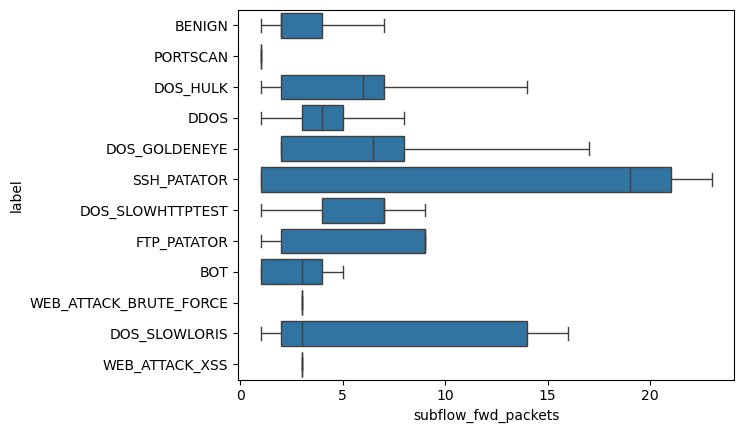

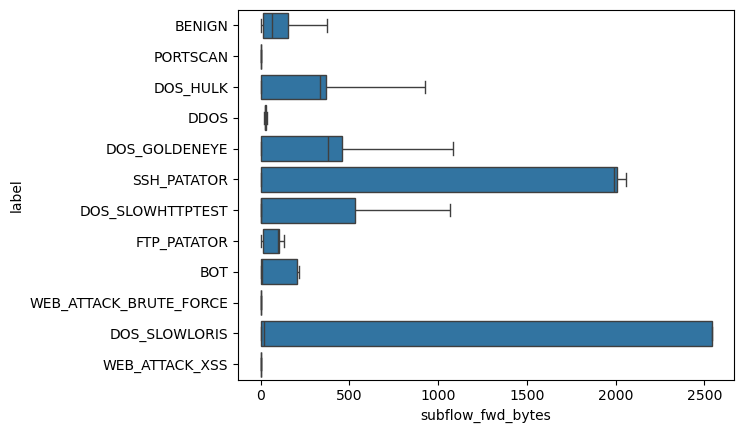

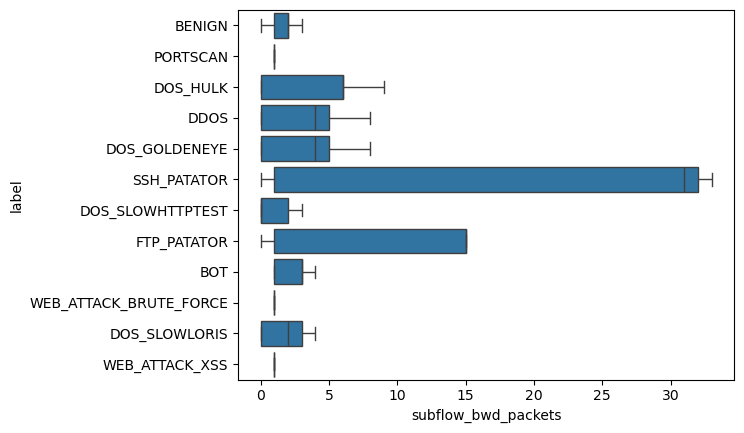

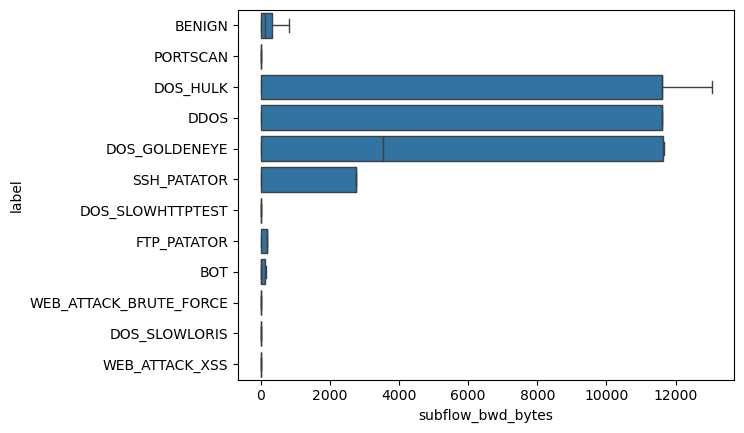

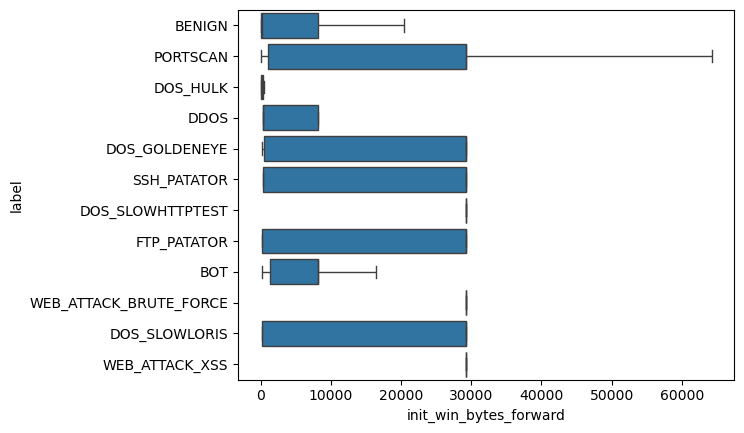

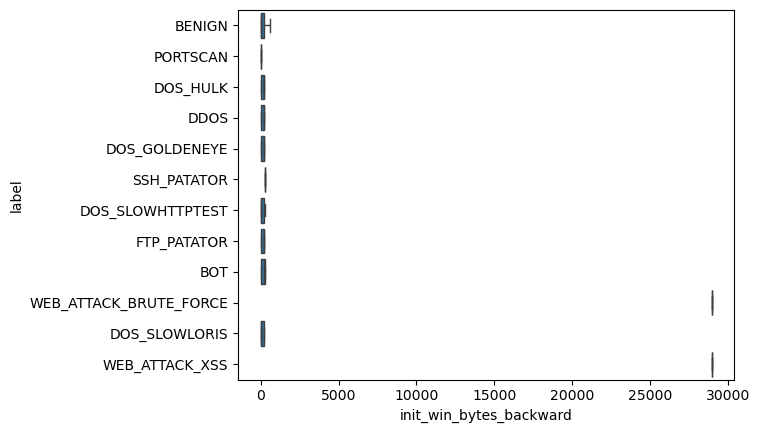

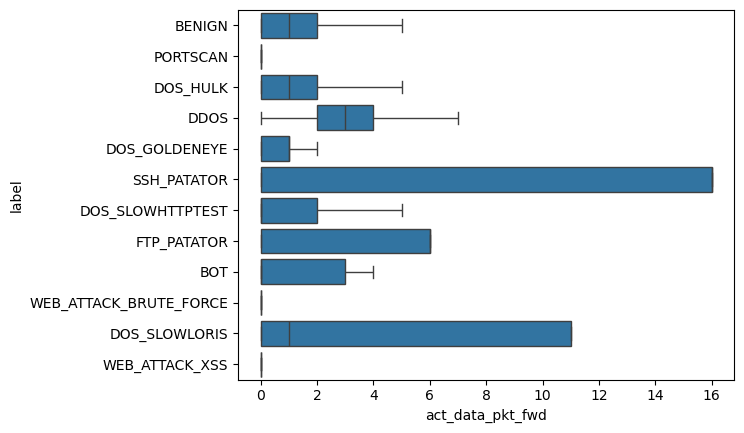

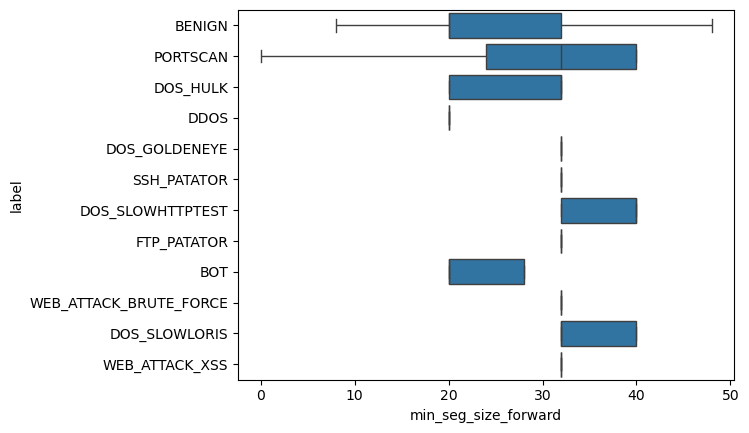

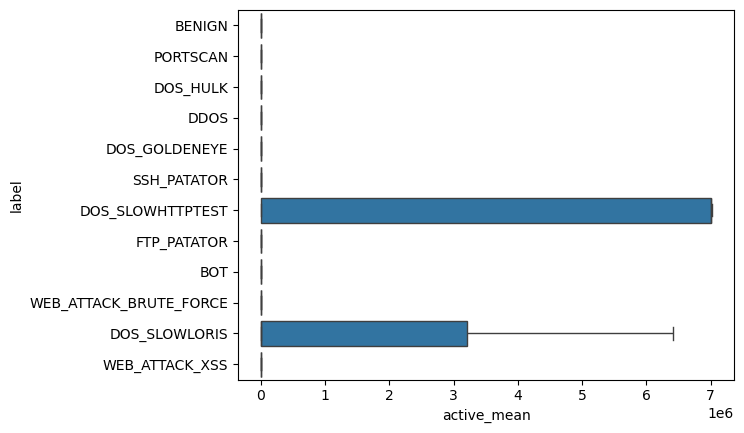

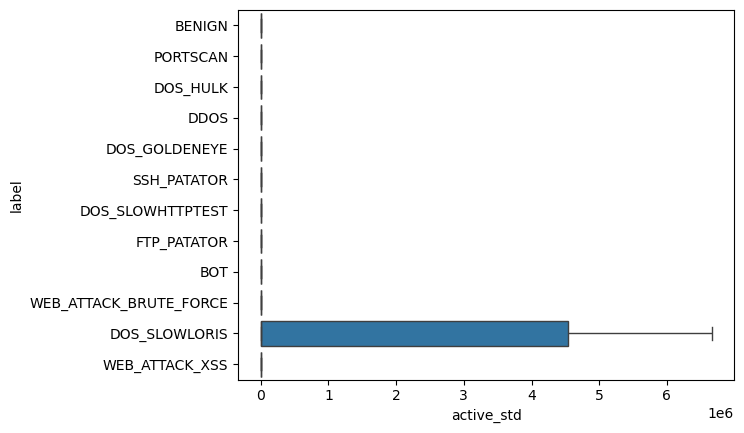

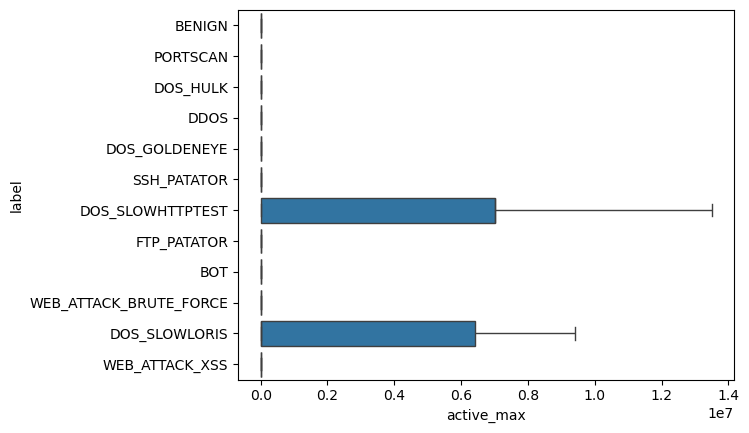

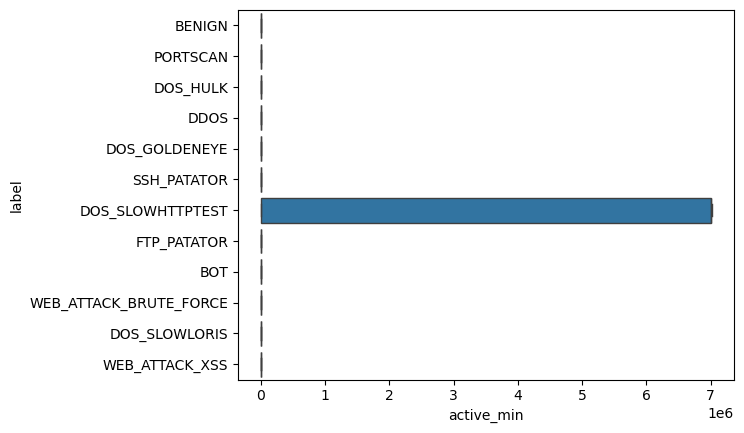

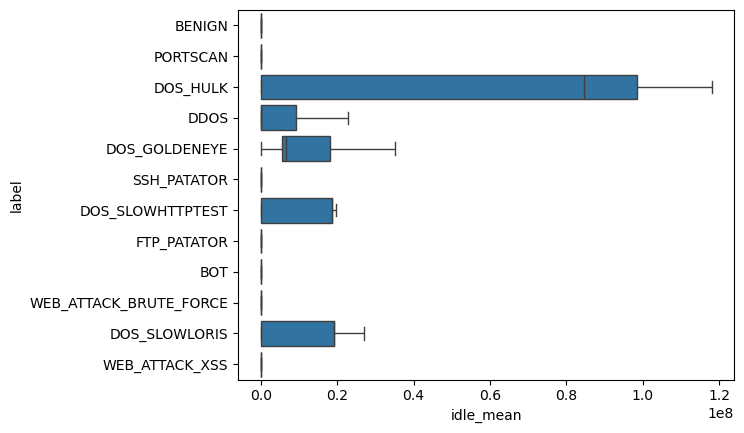

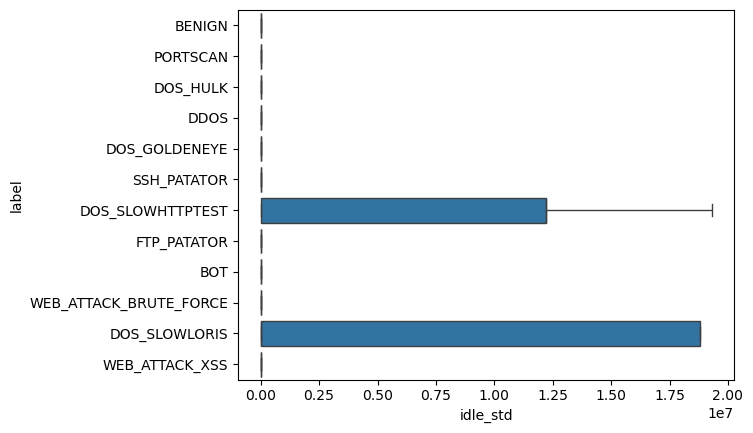

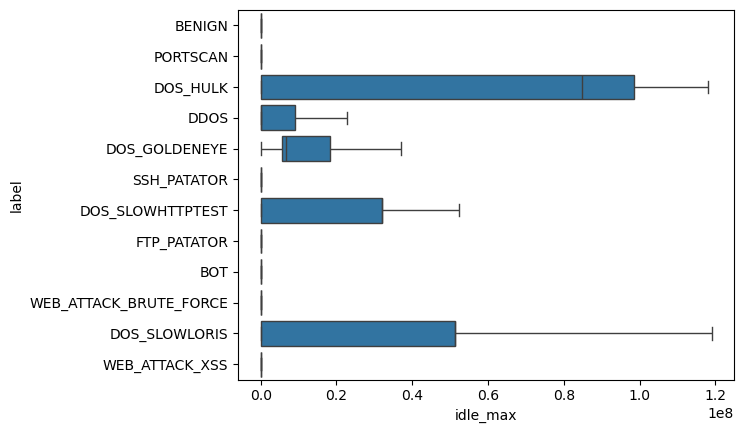

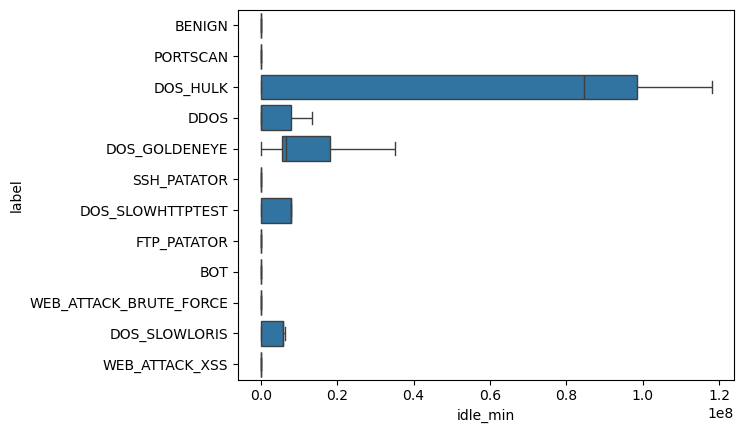

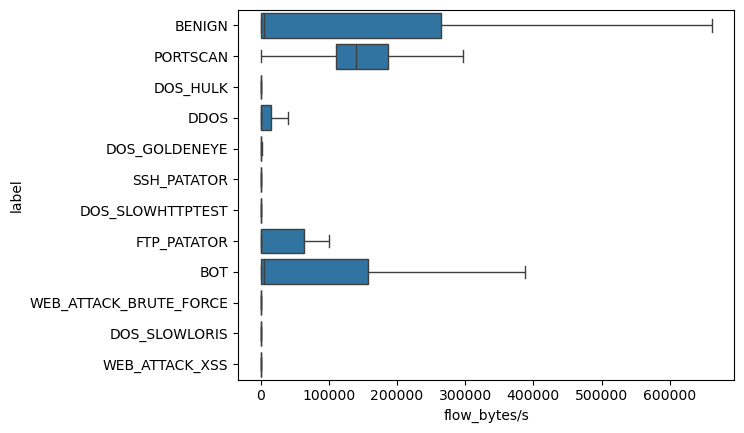

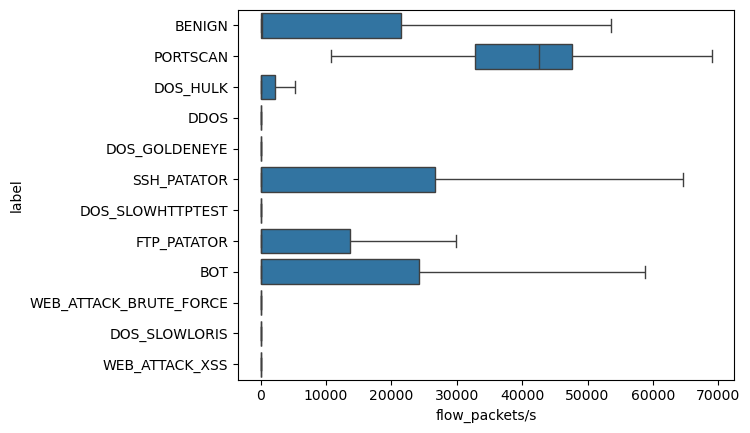

In [12]:
# Boxplots de las variables numéricas
if not EJECUCION_RAPIDA : 
  for i in caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito : 
    generateBoxplot(
      x=i,
      y="label",
      data=df,
      save_path=f"img/boxplots/boxplot_label_{i.replace("/","_").replace(".", "_")}"
    )

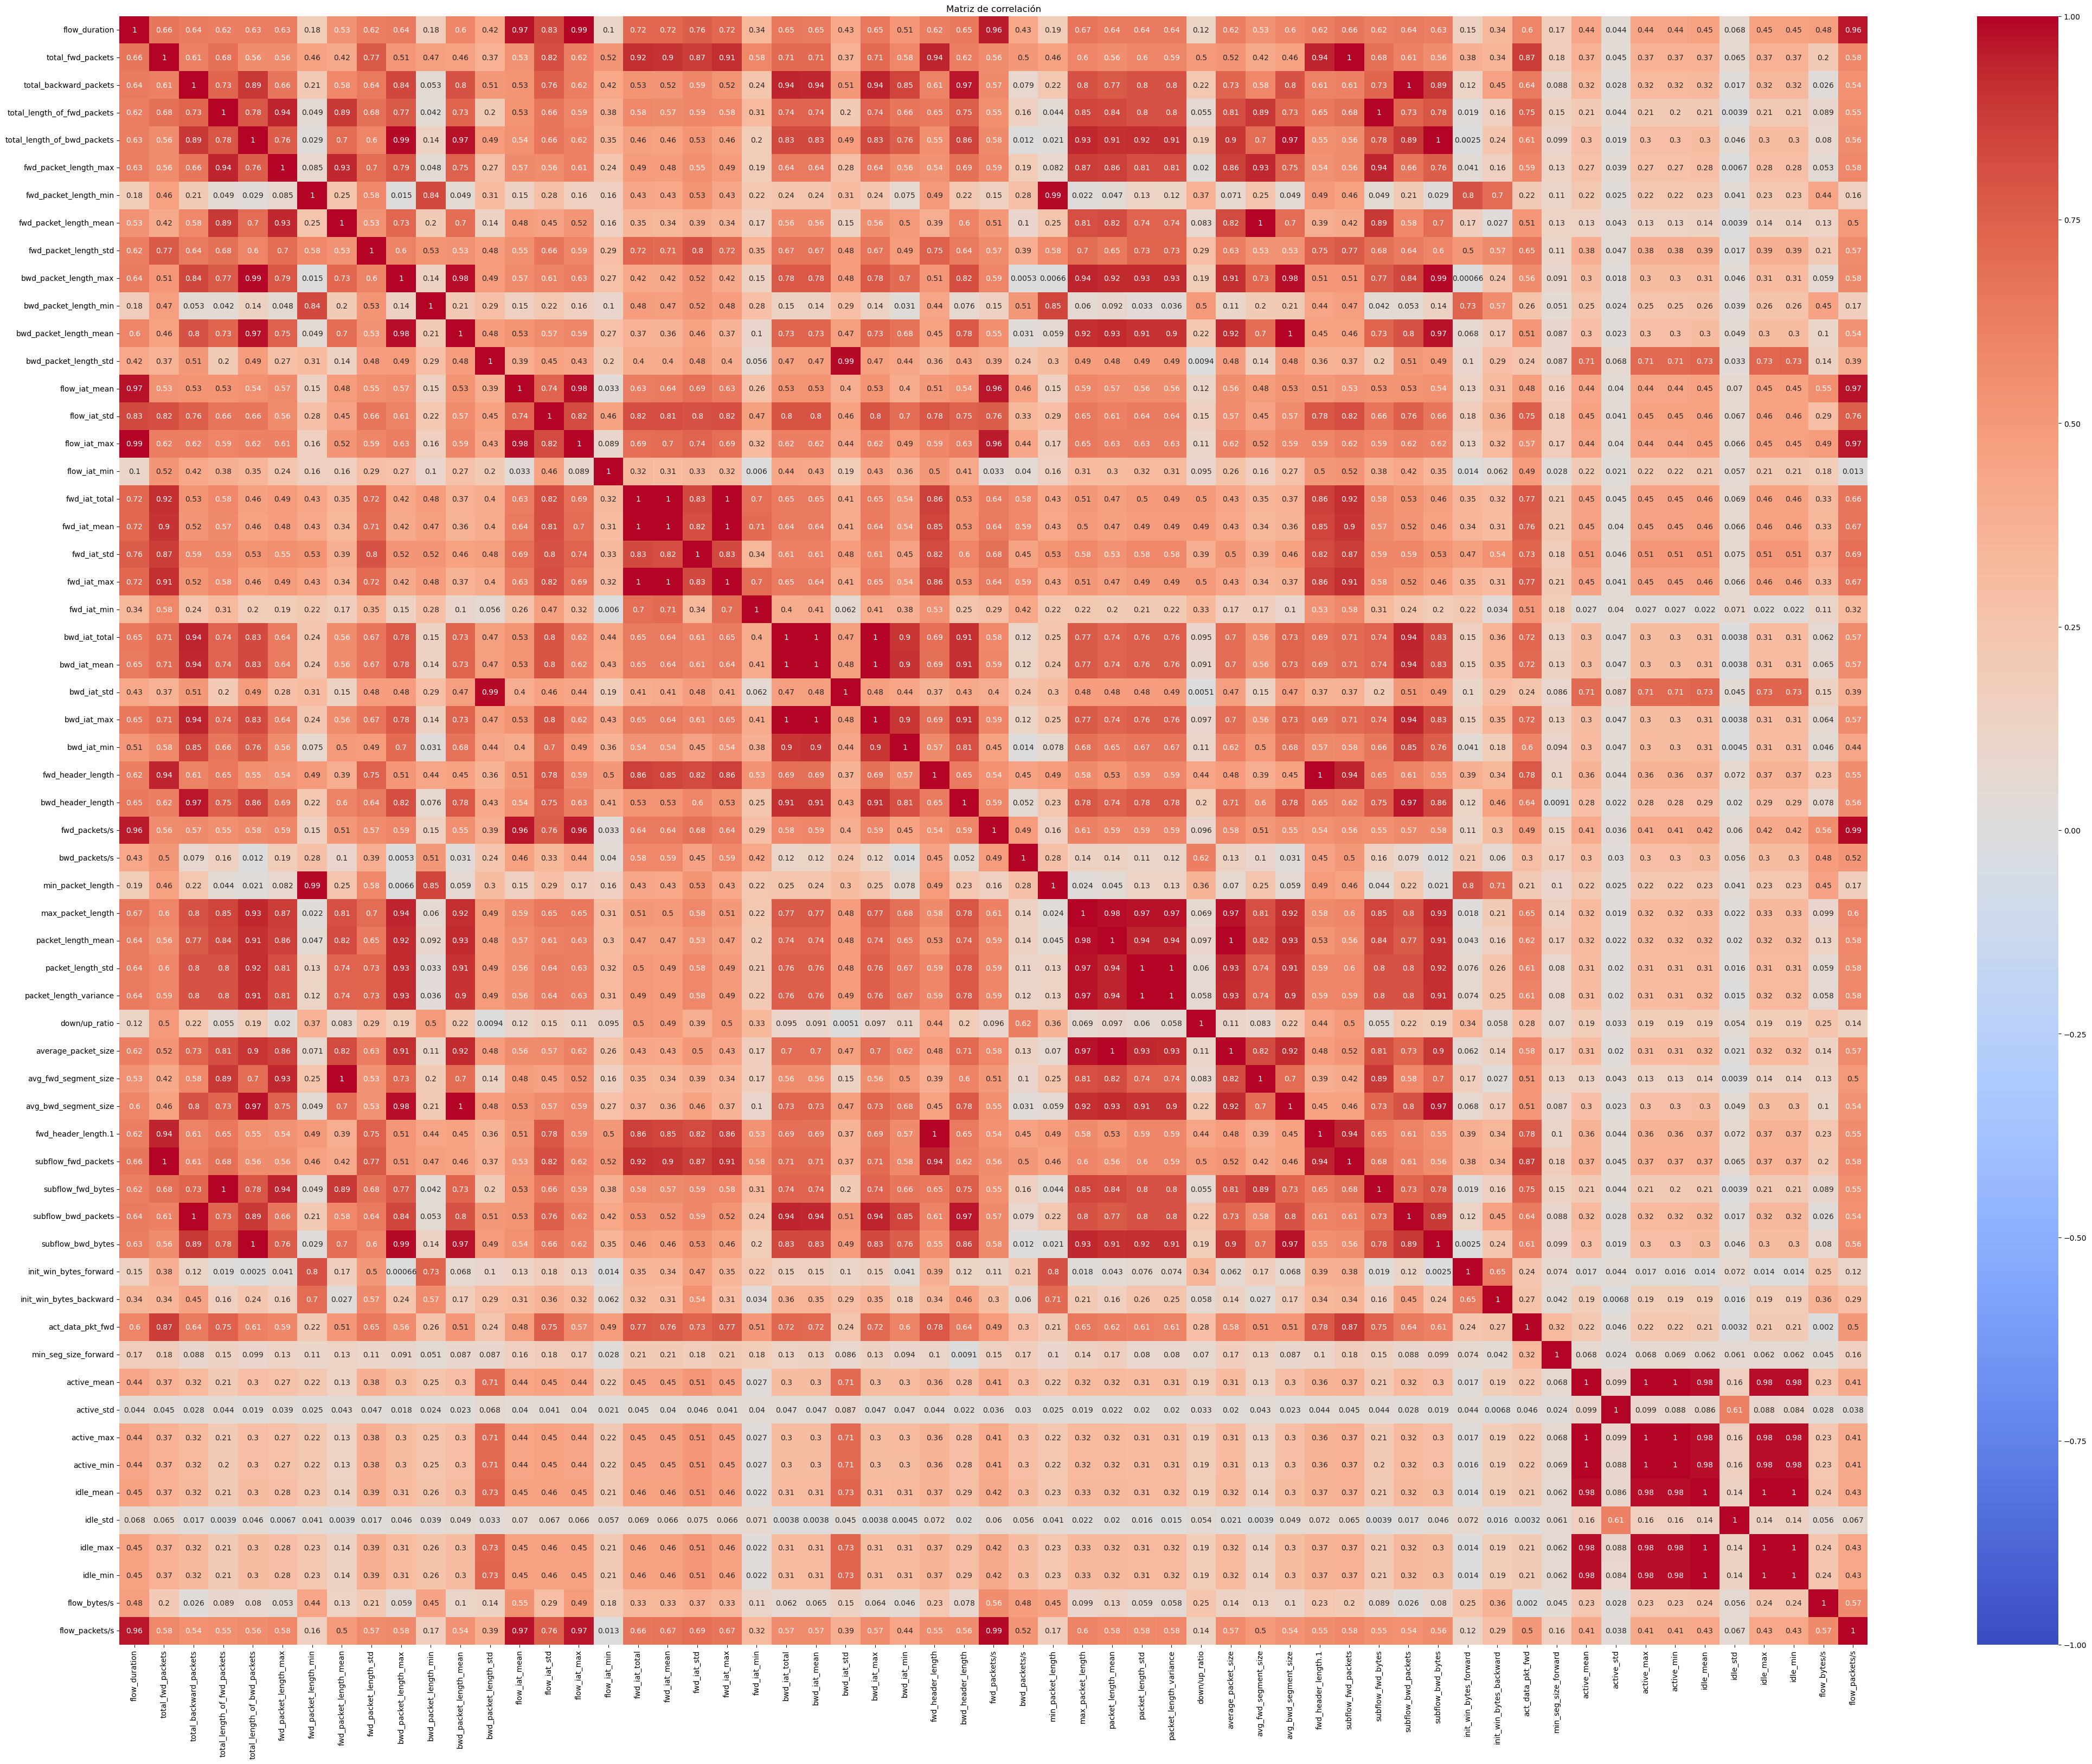

In [13]:
# Matriz de correlación
if not EJECUCION_RAPIDA : 
  generateCorrMatrix(
    data=df[caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito],
    decimals=2,
    save_path="img/matriz_correlacion_pearson_outliers_eliminados_no_normalizada.png",
    method="spearman"
  )

## Construcción de nuevos datos e Integración de datos

### 1. Normalización de datos

In [14]:
# scaler para normalizar datos
scaler = MinMaxScaler()
nrmlzd_cols = scaler.fit_transform(df[caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito])

In [15]:
df_nrmlzd = pd.DataFrame(
  nrmlzd_cols,
  columns=caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito
)
df_nrmlzd[caracteristicas_binarias] = df[caracteristicas_binarias]
df_nrmlzd["label"] = df["label"]
print(df_nrmlzd.columns)
print(df_nrmlzd.shape)

Index(['flow_duration', 'total_fwd_packets', 'total_backward_packets',
       'total_length_of_fwd_packets', 'total_length_of_bwd_packets',
       'fwd_packet_length_max', 'fwd_packet_length_min',
       'fwd_packet_length_mean', 'fwd_packet_length_std',
       'bwd_packet_length_max', 'bwd_packet_length_min',
       'bwd_packet_length_mean', 'bwd_packet_length_std', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_header_length', 'bwd_header_length',
       'fwd_packets/s', 'bwd_packets/s', 'min_packet_length',
       'max_packet_length', 'packet_length_mean', 'packet_length_std',
       'packet_length_variance', 'down/up_ratio', 'average_packet_size',
       'avg_fwd_segment_size', 'avg_bwd_segment_size', 'fwd_header_length.1',
       'subflow_fwd_packets', 'subflow_fwd_bytes', 'sub

### 2. Pruebas de supuestos estadísticos

In [16]:
# Una técnica de reducción de dimensionalidad con PCA es evaluar la correlación entre las características con la variable objetivo
# Dichas características deben guardar correlación y una varianza significativas para asegurar que PCA no causará perdida de información
# Para evaluar dichas métricas se utilizará el Test de Bartlett y KMO 

#### 2.1. Matriz de correlación

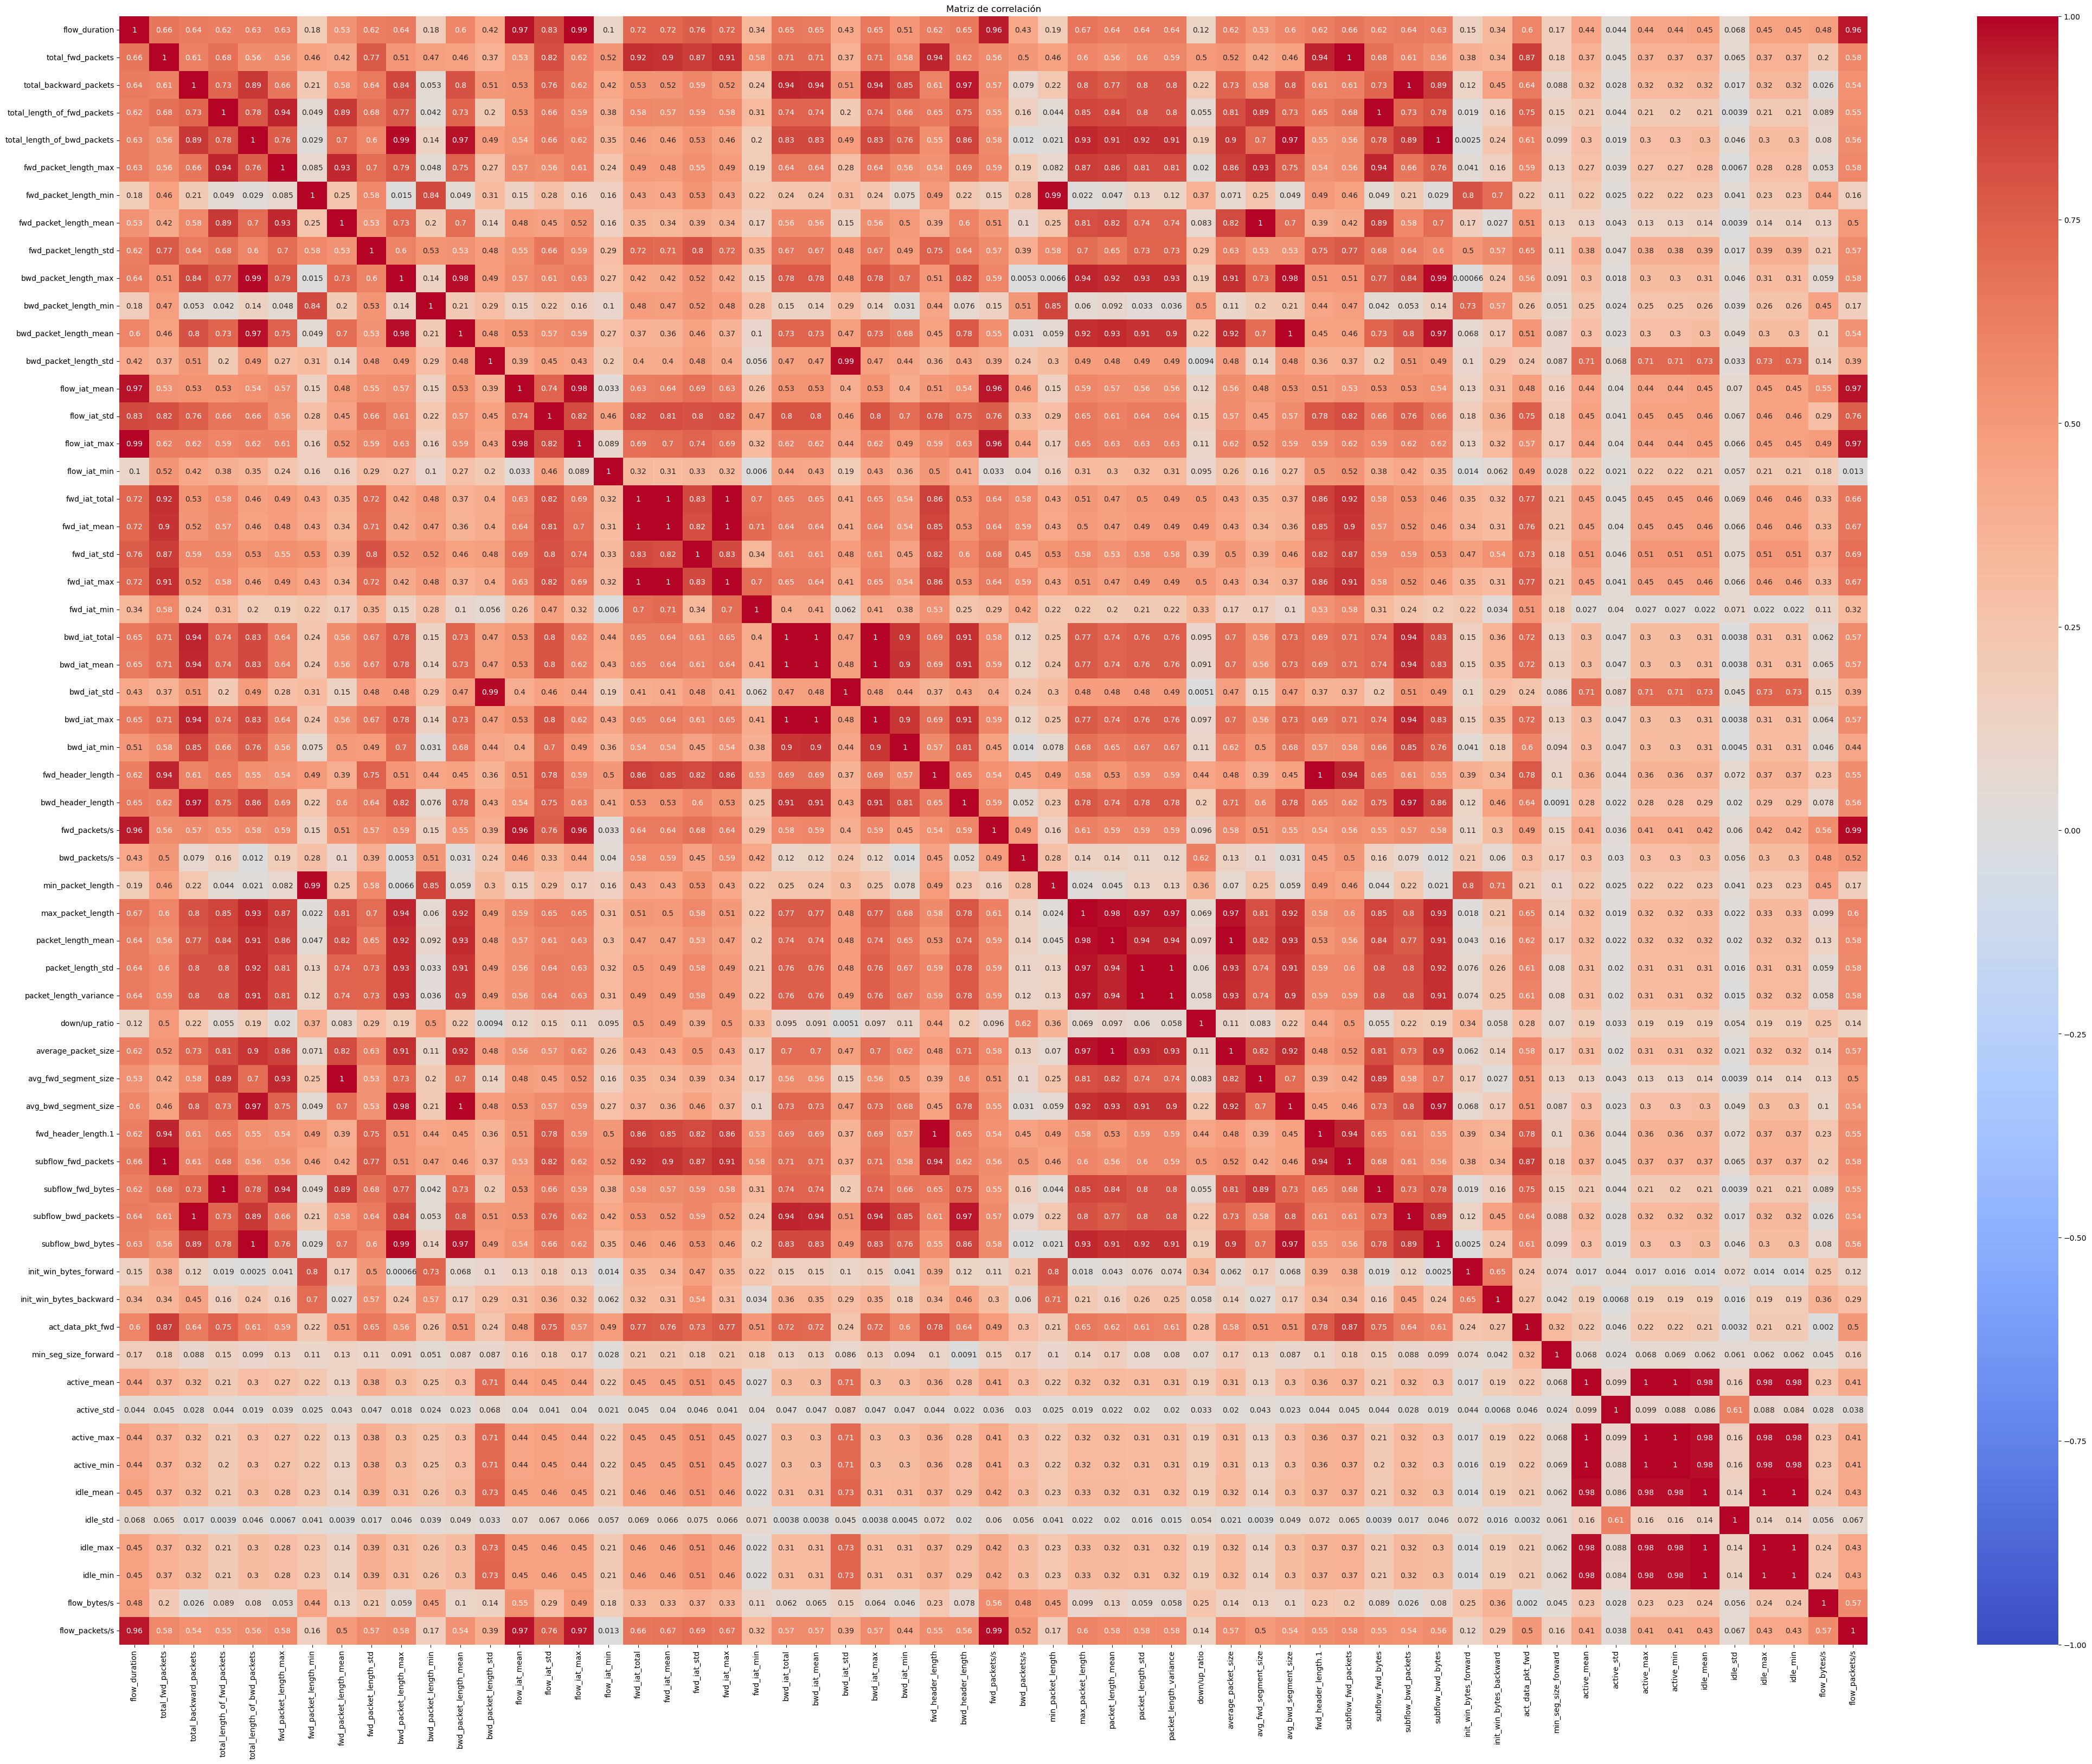

In [17]:
generateCorrMatrix(
  data=df_nrmlzd[caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito],
  save_path="img/matriz_correlacion_normalized",
  method="spearman"
)

In [18]:
corr = df_nrmlzd[caracteristicas_numericas+caracteristicas_con_valor_maximo_infinito].corr(method="spearman").abs()

np.fill_diagonal(corr.values, 0)

caracteristicas_no_aptas_para_pca = [c for c in corr.columns if any(corr[c] == 1.0) and corr[c].sum() > 1]
print(caracteristicas_no_aptas_para_pca)
print(len(caracteristicas_no_aptas_para_pca))

caracteristicas_numericas_filtradas = df_nrmlzd.drop(caracteristicas_binarias+caracteristicas_no_aptas_para_pca+["label"], axis=1).columns

print(caracteristicas_numericas_filtradas)
print(len(caracteristicas_numericas_filtradas))

['total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 'fwd_packet_length_mean', 'bwd_packet_length_mean', 'fwd_header_length', 'avg_fwd_segment_size', 'avg_bwd_segment_size', 'fwd_header_length.1', 'subflow_fwd_packets', 'subflow_fwd_bytes', 'subflow_bwd_packets', 'subflow_bwd_bytes']
14
Index(['flow_duration', 'fwd_packet_length_max', 'fwd_packet_length_min',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_std', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'down/up_ratio',
       'average_packe

#### 2.2. Correlación entre variables numéricas

##### 2.2.1. Test de Bartlett

In [19]:
# El test de Bartlett propone que las muestras provienen de muestras con varianzas iguales
# Si el p_value es menor al nivel de significancia (0.05) se puede rechazar la hipótesis nula y asegurar que existe varianza entre los grupos
# Hipótesis nula: No existe correlación entre las características numéricas
# Hipótesis alterna: Existe correlación entre las características numéricas}
# Se puede rechazar la hipótesis nula

x = df_nrmlzd[caracteristicas_numericas_filtradas].values

print(x.shape)

stat, p_value = calculate_bartlett_sphericity(x)

print(f"""Prueba de esfericidad de Bartlett
      Estadístico: {stat:.4f}
      Valor p:     {p_value:.4f}
""")

(141491, 45)
Prueba de esfericidad de Bartlett
      Estadístico: 20499838.1347
      Valor p:     0.0000



##### 2.2.1. KMO

In [20]:
# El índice KMO de las características es superior a 0.8, por lo que es perfectamente aplicable para reducción de dimensionalidad con PCA
kmo_all, kmo_model = calculate_kmo(df_nrmlzd[caracteristicas_numericas_filtradas])
print(f"Índice KMO general: {kmo_model:.4f}")

Índice KMO general: 0.8165


/home/coke/anaconda3/envs/ids_thesis/lib/python3.12/site-packages/factor_analyzer/utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


##### 2.2.3. Correlación de variables numéricas no aptas para reducción de dimensionalidad

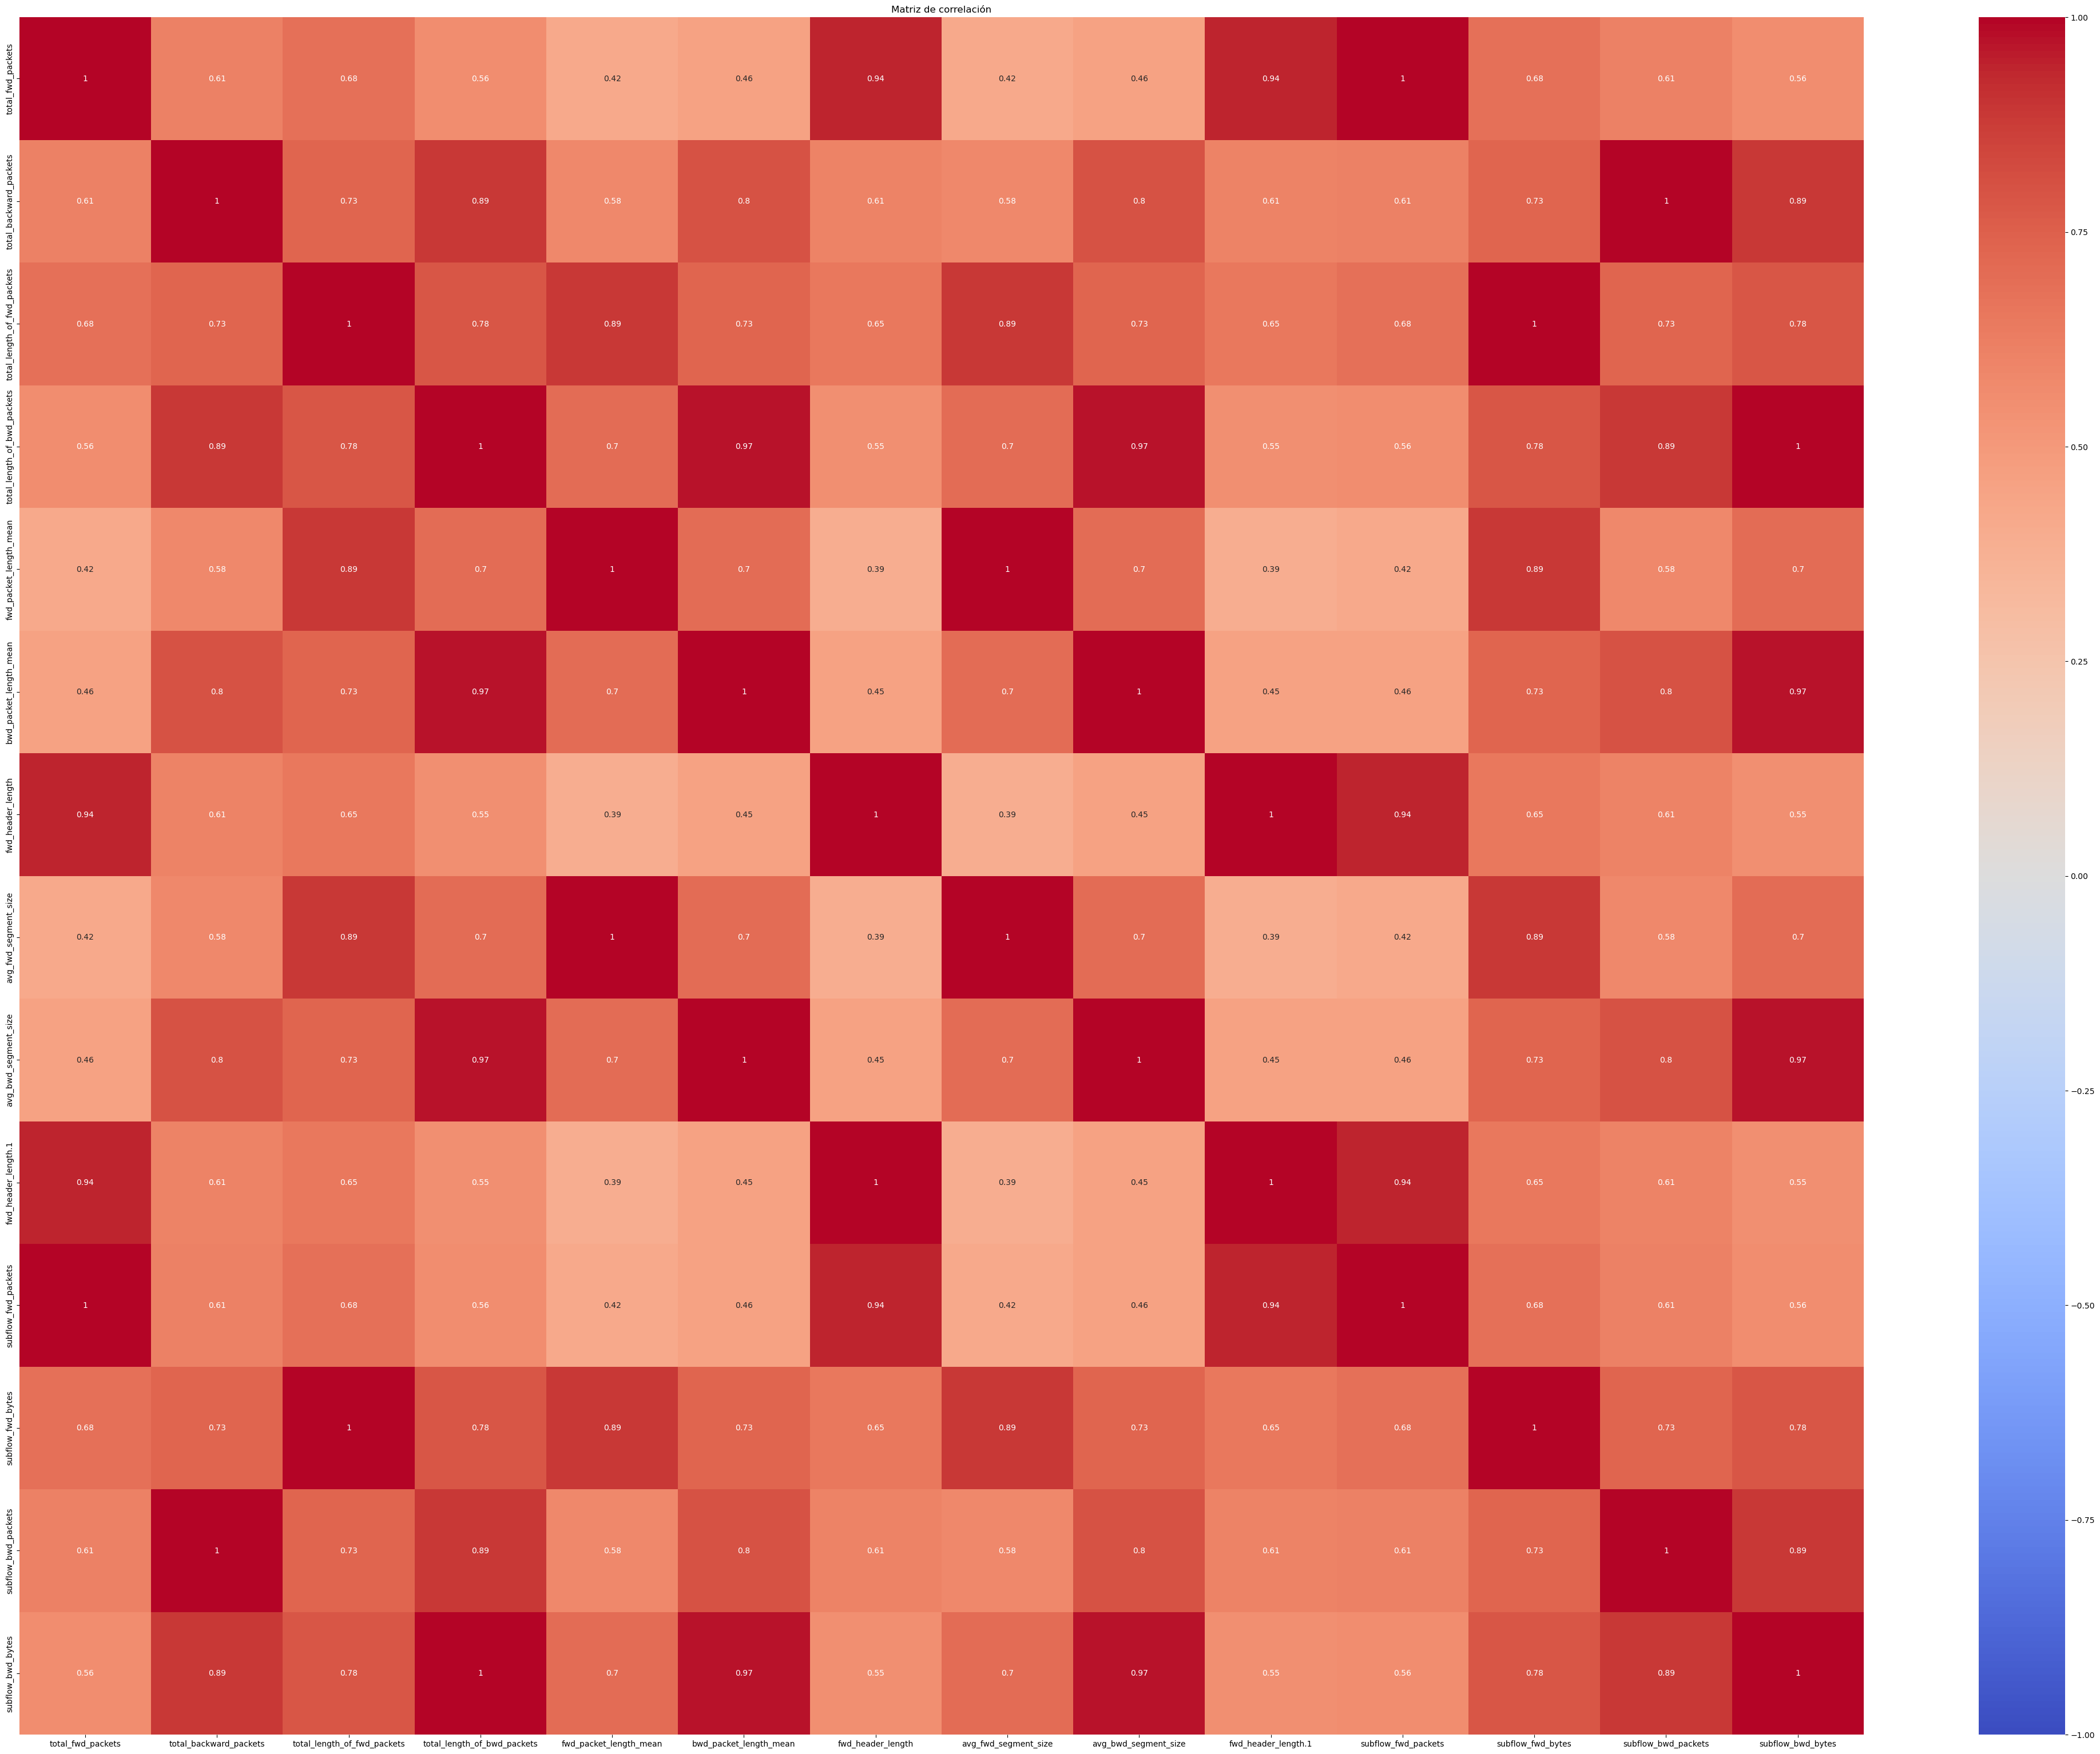

In [21]:
generateCorrMatrix(
  data=df_nrmlzd[caracteristicas_no_aptas_para_pca],
  save_path="img/matriz_correlacion_caracteristicas_no_aptas_para_pca",
  method="spearman",
  height=2,
  width=1.5
)

### 3. Principal Component Analysis (PCA)

In [22]:
n_components = 3

pca = PCA(n_components=n_components)

X_reduced = pca.fit_transform(df_nrmlzd[caracteristicas_numericas_filtradas])

In [23]:
df_reduced = pd.DataFrame(X_reduced, columns=[f"component_{i}" for i in range(n_components)])
df_reduced[caracteristicas_binarias+caracteristicas_no_aptas_para_pca+["label"]] = df_nrmlzd[caracteristicas_binarias+caracteristicas_no_aptas_para_pca+["label"]]
df_reduced

component_0  component_1  component_2  fwd_psh_flags  fwd_urg_flags  \
0          0.122641    -0.595606     0.486748              0              0   
1          0.617538     0.915599    -0.337928              0              0   
2         -1.988283     0.626264     0.276782              0              0   
3          0.376156     0.440923    -0.226715              0              0   
4          0.123452     0.115139    -0.487784              0              0   
...             ...          ...          ...            ...            ...   
141486     0.297860     0.342278    -0.351814              0              0   
141487     0.133305    -0.581472     0.477434              0              0   
141488     0.730137     1.006408     0.089181              0              0   
141489    -0.034897    -0.289898    -0.274034              0              0   
141490     0.252296     0.250714    -0.336631              0              0   

        fin_flag_count  syn_flag_count  rst_flag_count  psh_flag_count  \
0                    0               0               0               0   
1                    0               0               0               1   
2                    0               0               0               0   
3                    0               0               0               1   
4                    1               0               0               0   
...                ...             ...             ...             ...   
141486               0               0               0               0   
141487               0               0               0               0   
141488               0               0               0               0   
141489               1               0               0               0   
141490               0               0               0               0   

        ack_flag_count  ...  bwd_packet_length_mean  fwd_header_length  \
0                    0  ...                0.038790           0.026882   
1                    0  ...                0.001552           0.053763   
2                    1  ...                0.499741           0.397849   
3                    0  ...                0.001552           0.032258   
4                    0  ...                0.000000           0.080645   
...                ...  ...                     ...                ...   
141486               1  ...                0.000000           0.043011   
141487               0  ...                0.029739           0.043011   
141488               1  ...                0.001552           0.026882   
141489               0  ...                0.000000           0.053763   
141490               1  ...                0.000000           0.043011   

        avg_fwd_segment_size  avg_bwd_segment_size  fwd_header_length.1  \
0                   0.166783              0.038790             0.026882   
1                   0.000000              0.001552             0.053763   
2                   0.492912              0.499741             0.397849   
3                   0.006294              0.001552             0.032258   
4                   0.000000              0.000000             0.080645   
...                      ...                   ...                  ...   
141486              0.000000              0.000000             0.043011   
141487              0.188811              0.029739             0.043011   
141488              0.018881              0.001552             0.026882   
141489              0.018881              0.000000             0.053763   
141490              0.000000              0.000000             0.043011   

        subflow_fwd_packets  subflow_fwd_bytes  subflow_bwd_packets  \
0                  0.000000           0.020858             0.030303   
1                  0.000000           0.000000             0.030303   
2                  0.363636           0.363636             0.181818   
3                  0.000000           0.000787             0.030303   
4                  0.0909

In [24]:
# Resumen de características
print(f"""
Características categóricas
      
Características nominales: {len(caracteristicas_nominales)}
{caracteristicas_nominales}

Características politómicas: {len(caracteristicas_binarias)}
{caracteristicas_binarias}

Características numéricas

Características aptas para PCA: {len(caracteristicas_numericas_filtradas)}
{caracteristicas_numericas_filtradas}

Características no aptas para PCA: {len(caracteristicas_no_aptas_para_pca)}
{caracteristicas_no_aptas_para_pca}
""")


Características categóricas
      
Características nominales: 2
['destination_port', 'label']

Características politómicas: 10
['fwd_psh_flags', 'fwd_urg_flags', 'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 'cwe_flag_count', 'ece_flag_count']

Características numéricas

Características aptas para PCA: 45
Index(['flow_duration', 'fwd_packet_length_max', 'fwd_packet_length_min',
       'fwd_packet_length_std', 'bwd_packet_length_max',
       'bwd_packet_length_min', 'bwd_packet_length_std', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
       'min_packet_length', 'max_packet_length', 'packet_length_mean',
       'packet_length_std', 'packet_length_variance', 'down/up_rati

## Formato de datos

### 1. Transformador

In [5]:
# Se integran todos los métodos utilizados para automatizar el formato de datos
class IDSFeatureTransformer(BaseEstimator, TransformerMixin) :
  def __init__(self):
    super().__init__()
    self.fited = False
    self.seed = 9603
    self.n_components = 3
    self.scaler = MinMaxScaler()
    self.pca = PCA(n_components=self.n_components)
    self.pca_char_list = [f"component_{i+1}" for i in range(self.n_components)]
    self.obj_var_name = "label"
    self.null_char_name = "flow_bytes/s"
    self.inf_chars_names = ["flow_bytes/s", "flow_packets/s"]
    self.binary_chars  = ['fwd_psh_flags', 'fwd_urg_flags', 
        'fin_flag_count', 'syn_flag_count', 'rst_flag_count', 
        'psh_flag_count', 'ack_flag_count', 'urg_flag_count', 
        'cwe_flag_count', 'ece_flag_count']
    self.no_pca_chars = ['total_fwd_packets', 'total_backward_packets', 
        'total_length_of_fwd_packets', 'total_length_of_bwd_packets', 
        'fwd_packet_length_mean', 'bwd_packet_length_mean', 'fwd_header_length', 
        'avg_fwd_segment_size', 'avg_bwd_segment_size', 'fwd_header_length.1', 
        'subflow_fwd_packets', 'subflow_fwd_bytes', 'subflow_bwd_packets', 
        'subflow_bwd_bytes']
    self.pca_chars = ['flow_duration', 'fwd_packet_length_max', 
        'fwd_packet_length_min', 'fwd_packet_length_std', 'bwd_packet_length_max',
        'bwd_packet_length_min', 'bwd_packet_length_std', 'flow_iat_mean',
        'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_total',
        'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
        'bwd_iat_total', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
        'bwd_iat_min', 'bwd_header_length', 'fwd_packets/s', 'bwd_packets/s',
        'min_packet_length', 'max_packet_length', 'packet_length_mean',
        'packet_length_std', 'packet_length_variance', 'down/up_ratio',
        'average_packet_size', 'init_win_bytes_forward',
        'init_win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward',
        'active_mean', 'active_std', 'active_max', 'active_min', 'idle_mean',
        'idle_std', 'idle_max', 'idle_min', 'flow_bytes/s', 'flow_packets/s']
    self.no_util_chars = ['bwd_psh_flags', 'bwd_urg_flags', 
      'fwd_avg_bytes/bulk', 'fwd_avg_packets/bulk', 'fwd_avg_bulk_rate', 
      'bwd_avg_bytes/bulk', 'bwd_avg_packets/bulk', 'bwd_avg_bulk_rate']
  
  def column_transform(self, df : pd.DataFrame) :
    df_new = df.copy()
    df_new.columns = df_new.columns.str.strip().str.lower().str.replace(" ", "_")
    return df_new
  
  def obj_v_clean(self, df : pd.DataFrame) : 
    df_new = df.copy()
    df_new[self.obj_var_name] = df_new[self.obj_var_name].str.upper().str.replace("� ", "").str.replace(" ", "_").str.replace("-", "_")
    return df_new
  
  def data_selection(self, df : pd.DataFrame) :
    df_new = df.copy()
    df_new = df_new.drop(self.no_util_chars, axis=1)
    return df_new
  
  def flow_bytes_s_null_values_imputation(self, df : pd.DataFrame) : 
    df_new = df.copy() 
    if not self.fited : 
      null_values_list = df_new[df_new[self.null_char_name].isna()][self.obj_var_name].unique().tolist()

      for i in null_values_list : 
        median = df_new[df_new[self.obj_var_name] == i][self.null_char_name].median()

        df_new.loc[df_new[self.null_char_name].isnull() & (df_new[self.obj_var_name] == i), self.null_char_name] = median

      self.flow_bytes_s_median = df_new[self.null_char_name].median()
      return df_new
    else : 
      df_new.loc[df_new[self.null_char_name].isnull(), self.null_char_name] = self.flow_bytes_s_median

      return df_new

  def manageOutliersToMinMax(self, df : pd.DataFrame) :
    def get_bounds_and_valids(df : pd.DataFrame, char) :
      q1 = subset[char].quantile(0.25)
      q3 = subset[char].quantile(0.75)
      iqr = q3 - q1
      lower_bound = q1 - 1.5 * iqr
      upper_bound = q3 + 1.5 * iqr

      valid_values = subset[(subset[char] >= lower_bound) & (subset[char] <= upper_bound)][char]
      valid_min = valid_values.min()
      valid_max = valid_values.max()

      return lower_bound, upper_bound, valid_min, valid_max

    df_new = df.copy()
    if not self.fited :
      self.min_max_manager = []
      
      for i in self.pca_chars+self.no_pca_chars :
        for tag_obj in df[self.obj_var_name].unique() :
          subset = df[df[self.obj_var_name] == tag_obj]

          lower_bound, upper_bound, valid_min, valid_max = get_bounds_and_valids(subset, i)

          mask = df[self.obj_var_name] == tag_obj
          df_new.loc[mask & (df[i] < lower_bound), i] = valid_min
          df_new.loc[mask & (df[i] > upper_bound), i] = valid_max
      for i in range(len(self.inf_chars_names)) :
        lower_bound, upper_bound, valid_min, valid_max = get_bounds_and_valids(df_new[self.inf_chars_names[i]], self.inf_chars_names[i])
        self.min_max_manager.append({
          "char" : self.inf_chars_names[i],
          "lower_bound" : lower_bound,
          "upper_bound" : upper_bound,
          "valid_min" : valid_min,
          "valid_max" : valid_max
        })
      return df_new
    else : 
      for i in self.min_max_manager : 
        df_new.loc[(df[i["char"]] < i["lower_bound"]), i["char"]] = i["valid_min"]
        df_new.loc[(df[i["char"]] > i["upper_bound"]), i["char"]] = i["valid_max"]
      return df_new

  def fit_transform(self, df : pd.DataFrame):
    df_new = df.copy()
    df_new = self.column_transform(df_new)
    df_new = self.obj_v_clean(df_new)

    """ Selección de datos relevantes """
    df_new = self.data_selection(df_new)

    """ Limpieza de datos """
    df_new = self.flow_bytes_s_null_values_imputation(df_new)
    df_new = self.manageOutliersToMinMax(df_new)

    """ Construcción de nuevos datos """
    X_nrmlzd = self.scaler.fit_transform(df_new[self.pca_chars+self.no_pca_chars])
    df_nrmlzd = pd.DataFrame(X_nrmlzd, columns=self.pca_chars+self.no_pca_chars)

    X_pca = self.pca.fit_transform(df_nrmlzd[self.pca_chars])
    df_pca = pd.DataFrame(X_pca, columns=self.pca_char_list)

    """ Integración de datos """
    df_chars_reduced = df_new[self.binary_chars+[self.obj_var_name]]
    df_chars_reduced[self.no_pca_chars] = df_nrmlzd[self.no_pca_chars]
    df_chars_reduced[self.pca_char_list] = df_pca[self.pca_char_list]

    """ Formato de datos """
    X_chars_reduced = df_chars_reduced.drop([self.obj_var_name], axis=1)
    y_chars_reduced = df_chars_reduced["label"]

    self.fited = True

    return X_chars_reduced, y_chars_reduced

  def transform_test(self, df : pd.DataFrame):
    if not self.fited : 
      print("Debe utilizar fit() primero")
    else : 
      df_new = df.copy()
      df_new = self.column_transform(df_new)
      df_new = self.obj_v_clean(df_new)

      """ Selección de datos relevantes """
      df_new = self.data_selection(df_new)

      """ Limpieza de datos """
      df_new = self.flow_bytes_s_null_values_imputation(df_new)
      df_new = self.manageOutliersToMinMax(df_new)

      """ Construcción de nuevos datos """
      X_nrmlzd = self.scaler.transform(df_new[self.pca_chars+self.no_pca_chars])
      df_nrmlzd = pd.DataFrame(X_nrmlzd, columns=self.pca_chars+self.no_pca_chars)

      X_pca = self.pca.transform(df_nrmlzd[self.pca_chars])
      df_pca = pd.DataFrame(X_pca, columns=self.pca_char_list)

      """ Integración de datos """
      df_chars_reduced = df_new[self.binary_chars+[self.obj_var_name]]
      df_chars_reduced[self.no_pca_chars] = df_nrmlzd[self.no_pca_chars]
      df_chars_reduced[self.pca_char_list] = df_pca[self.pca_char_list]

      """ Formato de datos """
      X_chars_reduced = df_chars_reduced.drop([self.obj_var_name], axis=1)
      y_chars_reduced = df_chars_reduced["label"]

      return X_chars_reduced, y_chars_reduced

  def transform(self, df : pd.DataFrame):
    if not self.fited : 
      print("Debe utilizar fit() primero")
    else : 
      df_new = df.copy()
      df_new = self.column_transform(df_new)

      """ Selección de datos relevantes """
      df_new = self.data_selection(df_new)

      """ Limpieza de datos"""
      df_new = self.flow_bytes_s_null_values_imputation(df_new)

      """ Construcción de nuevos datos """
      X_nrmlzd = self.scaler.transform(df_new[self.pca_chars+self.no_pca_chars])
      df_nrmlzd = pd.DataFrame(X_nrmlzd, columns=self.pca_chars+self.no_pca_chars)

      X_pca = self.pca.transform(df_nrmlzd[self.pca_chars])
      df_pca = pd.DataFrame(X_pca, columns=self.pca_char_list)

      """ Integración de datos """
      df_chars_reduced = df_new[self.binary_chars]
      df_chars_reduced[self.no_pca_chars] = df_nrmlzd[self.no_pca_chars]
      df_chars_reduced[self.pca_char_list] = df_pca[self.pca_char_list]

      return df_chars_reduced

transformer = IDSFeatureTransformer()

### 2. Carga de datos

In [6]:
df_train = pd.read_csv(f"{dataset_path}{db_files_name[0]}")
df_test  = pd.read_csv(f"{dataset_path}{db_files_name[1]}") 

### 3. Entrenamiento del transformador

In [7]:
X_train, y_train = transformer.fit_transform(df_train)
X_train

/tmp/ipykernel_66290/667477602.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chars_reduced[self.no_pca_chars] = df_nrmlzd[self.no_pca_chars]
/tmp/ipykernel_66290/667477602.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chars_reduced[self.no_pca_chars] = df_nrmlzd[self.no_pca_chars]
/tmp/ipykernel_66290/667477602.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

fwd_psh_flags  fwd_urg_flags  fin_flag_count  syn_flag_count  \
0                   0              0               0               0   
1                   0              0               0               0   
2                   0              0               0               0   
3                   0              0               0               0   
4                   0              0               0               0   
...               ...            ...             ...             ...   
399995              0              0               0               0   
399996              0              0               0               0   
399997              0              0               0               0   
399998              0              0               0               0   
399999              0              0               1               0   

        rst_flag_count  psh_flag_count  ack_flag_count  urg_flag_count  \
0                    0               0               1               0   
1                    0               0               0               0   
2                    0               0               1               1   
3                    0               0               1               0   
4                    0               1               0               0   
...                ...             ...             ...             ...   
399995               0               1               0               0   
399996               0               1               0               0   
399997               0               1               0               0   
399998               0               1               0               0   
399999               0               0               0               0   

        cwe_flag_count  ece_flag_count  ...  avg_fwd_segment_size  \
0                    0               0  ...              0.023136   
1                    0               0  ...              0.142674   
2                    0               0  ...              0.023136   
3                    0               0  ...              0.064267   
4                    0               0  ...              0.142123   
...                ...             ...  ...                   ...   
399995               0               0  ...              0.394602   
399996               0               0  ...              0.222445   
399997               0               0  ...              0.000000   
399998               0               0  ...              0.007712   
399999               0               0  ...              0.000000   

        avg_bwd_segment_size  fwd_header_length.1  subflow_fwd_packets  \
0                   0.000000             0.089928              0.12500   
1                   0.026049             0.035971              0.03125   
2                   0.001547             0.017986              0.00000   
3                   0.001547             0.053957              0.06250   
4                   0.095276             0.169065              0.18750   
...                      ...                  ...                  ...   
399995              0.095276             0.064748              0.06250   
399996              0.095276             0.169065              0.18750   
399997              0.001547             0.035971              0.00000   
399998              0.001547             0.021583              0.00000   
399999              0.000000             0.035971              0.03125   

        subflow_fwd_bytes  subflow_bwd_packets  subflow_bwd_bytes  \
0                0.011329             0.000000           0.000000   
1                0.027946             0.046512           0.015487   
2                0.002266             0.023256           0.000460   
3                0.018882             0.023256           0.000460   
4                0.097432             0.069767           0.061259   
...                   ...                  ...                ...   
399995           0.115937             0.069767       

### 4. Conversión del dataset de pruebas

In [8]:
X_test, y_test = transformer.transform_test(df_test)
X_test

/tmp/ipykernel_66290/667477602.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chars_reduced[self.no_pca_chars] = df_nrmlzd[self.no_pca_chars]
/tmp/ipykernel_66290/667477602.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chars_reduced[self.no_pca_chars] = df_nrmlzd[self.no_pca_chars]
/tmp/ipykernel_66290/667477602.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

fwd_psh_flags  fwd_urg_flags  fin_flag_count  syn_flag_count  \
0                  0              0               0               0   
1                  0              0               0               0   
2                  0              0               0               0   
3                  0              0               0               0   
4                  0              0               0               0   
...              ...            ...             ...             ...   
99995              0              0               0               0   
99996              0              0               0               0   
99997              1              0               0               1   
99998              0              0               0               0   
99999              0              0               0               0   

       rst_flag_count  psh_flag_count  ack_flag_count  urg_flag_count  \
0                   0               0               0               0   
1                   0               1               0               0   
2                   0               0               1               0   
3                   0               0               1               1   
4                   0               0               0               0   
...               ...             ...             ...             ...   
99995               0               1               0               0   
99996               0               0               0               0   
99997               0               0               1               0   
99998               0               1               0               0   
99999               0               1               0               0   

       cwe_flag_count  ece_flag_count  ...  avg_fwd_segment_size  \
0                   0               0  ...              0.142674   
1                   0               0  ...              0.144602   
2                   0               0  ...              0.023136   
3                   0               0  ...              0.000000   
4                   0               0  ...              0.185090   
...               ...             ...  ...                   ...   
99995               0               0  ...              0.000000   
99996               0               0  ...              0.192802   
99997               0               0  ...              0.071337   
99998               0               0  ...              0.077763   
99999               0               0  ...              0.298201   

       avg_bwd_segment_size  fwd_header_length.1  subflow_fwd_packets  \
0                  0.026049             0.057554              0.03125   
1                  0.256461             0.582734              0.59375   
2                  0.000000             0.035971              0.03125   
3                  0.000000             0.028777              0.00000   
4                  0.012380             0.028777              0.00000   
...                     ...                  ...                  ...   
99995              0.000000             0.093525              0.06250   
99996              0.017022             0.017986              0.00000   
99997              0.000000             0.057554              0.03125   
99998              0.267366             0.183453              0.15625   
99999              0.039639             0.237410              0.34375   

       subflow_fwd_bytes  subflow_bwd_packets  subflow_bwd_bytes  component_1  \
0               0.027946             0.046512           0.015487    -0.227362   
1               0.283233             0.604651           1.982213     0.766261   
2               0.004532             0.000000           0.000000    -0.118846   
3               0.000000             0.023256           0.000000    -0.157094   
4               0.018127             0.023256           0.003680    -0.231222   
...                  ...                  ...                ...          ...   
99995           

### 5. Guardado de datos en el formato para entrenamiento de modelos de ML

In [9]:
df_output_list = [X_train, y_train, X_test, y_test]

for i in output_paths :
  for j in range(len(output_files_name)) : 
    df_output_list[j].to_csv(f"{i}{output_files_name[j]}", index=False)